In [65]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
# from ipywidgets import interact
# import ipywidgets as widgets
# import traitlets
import warnings
warnings.filterwarnings("ignore")
# from IPython.display import display, HTML
import os
import subprocess
import time
#from io import BytesIO as StringIO
from cStringIO import StringIO
import pickle
import zlib
import tifffile as tifg
#from scipy.ndimage.morphology import grey_dilation
# import PIL
from PIL import Image
# from PIL.ImageSequence import Iterator
import pandas as pd
from scipy.io import savemat, loadmat
from pandas.io import json
import tensorflow as tf

import NetTracker
from NetTracker import TrackingData

from datatank_py.DTDataFile import DTDataFile
from datatank_py.DTProgress import DTProgress
from datatank_py.DTSeries import DTSeriesGroup

matplotlib.style.use('seaborn')
matplotlib.rcParams.update({'font.family': 'Arial', 
                            'font.sans-serif': 'Arial',
                            'font.size': 24})

def getFiles(path, kind='tif'):
    kind = '.'+kind
    fn = len(kind)
    filenames = []
    for root, dirs, files in os.walk(path):
        for f in files:
            if f[-fn:] == kind:
                filenames.append(os.path.join(root, f[:-fn]))
    print('Total number of {0} files: '.format(kind[1:]), len(filenames))
    return filenames 

Populating the interactive namespace from numpy and matplotlib


In [61]:
imageSize = 128 # number of x,y image pixels
Nz = 17 # number of z-slices
zs = 1.8 # the z-scale factor, zs = dz/dxy
rmax = Nz*zs/2. # radius of the cylinder representing the hypha
# rmax = 45./2.
rmax_inner = rmax/2.
yc = imageSize/2. # center y coordinate of hypha
zc = (Nz - 1.)*zs/2. # center z coordinate of hypha
Vtot = 2.*pi*rmax**2*imageSize # total volume of hypha
# image pixel coordinates
ximg0 = array(
    [[[i, j]
        for i in arange(imageSize)]
            for j in arange(imageSize)])
zimg0 = zs*arange(Nz)

def makeTracks(Nparticles, Nframes, D0, Nsamp=16):
    """Generates Brownian motion tracks restricted to a cylindrical region.
    Nparticles: the total number of GEMS tracks
    Nframes: the number of time values for each tracks
    D0: a tuple containing the left half and right half diffusivity
    """
    def cylindrical_coords_r(x):
        y, z = x[..., 1], x[..., 2]
        r = sqrt((y - yc)**2 + (z - zc)**2)
        return r
    def D1(x):
        """left half low and right half high"""
        out = D0[1]*ones(Nparticles)
        inds = x[..., 0] < yc
        out[inds] = D0[0]
        return out
    def D2(x):
        """Small low zone in the center"""
        out = D0[1]*ones(Nparticles)
        inds = (
            (x[..., 0] > yc - 0.1*imageSize)
            &(x[..., 0] < yc + 0.1*imageSize)
            &(x[..., 1] > yc - rmax_inner)
            &(x[..., 1] < yc + rmax_inner)
            &(x[..., 2] > zc - rmax_inner)
            &(x[..., 2] < zc + rmax_inner))
        out[inds] = D0[0]
        return out
    if testType == 'testA':
        Dfun = D1
    elif testType == 'testB':
        Dfun = D2
    else:
        assert testType == 'testA' or testType == 'testB'
    DX = normal(0, sqrt(2.), (Nsamp*Nframes, Nparticles, 3))
    yzc = array([yc, zc])
    xmarg = 0.
    x0 = - xmarg + (imageSize + 2*xmarg)*rand(Nparticles, 1)
    r0 = rmax*sqrt(rand(Nparticles, 1))
    th0 = -pi + 2*pi*rand(Nparticles, 1)
    y0 = yc + r0*cos(th0)
    z0 = zc + r0*sin(th0)
    x0 = concatenate([x0, y0, z0], 1)
    out = zeros((Nsamp*Nframes, Nparticles, 3))
    out[0] = x0
    for t in arange(1, Nsamp*Nframes):
        Di = Dfun(out[t-1])
        dxi = (sqrt(Di/Nsamp)*DX[t].T).T
        xnew = out[t-1] + dxi
        out[t] = out[t-1] + (sqrt(Dfun(xnew)/Nsamp)*DX[t].T).T
        r = cylindrical_coords_r(out[t])
        inds = r > rmax
        for ind in arange(Nparticles)[inds]:
            p1 = out[t-1, ind, 1:] - yzc
            assert norm(p1) <= rmax
            p2 = out[t, ind, 1:] - yzc
            assert(norm(p2) > rmax)
            assert norm(p1) < norm(p2)
            pnew, pb = getReflectPoint(p1, p2, rmax)
            n_iter = 0
            while norm(pnew) >= rmax  and n_iter < 100:
                if n_iter > 90:
                    print(n_iter, norm(pnew), rmax, norm(pnew) - rmax)
                pold = pnew
                pnew, pb = getReflectPoint((rmax/norm(pb)-1e-14)*pb, pnew, rmax)
                n_iter += 1
            assert(norm(pnew) < rmax)
            out[t, ind, 1:] = yzc + pnew
        x = out[t, ..., 0]
        inds = x < 0. - xmarg
        out[t, inds, 0] = (2.*(0. - xmarg) - out[t, inds, 0])
        inds = x > imageSize + xmarg
        out[t, inds, 0] = (2.*(imageSize + xmarg) - out[t, inds, 0])
    return float32(out[::Nsamp])
def saveMD(name):
    outdict = {'Seq_NF': array([u'Real Number'], dtype='<U11'),
               'Seq_Nx': array([u'Real Number'], dtype='<U11'),
               'Seq_Ny': array([u'Real Number'], dtype='<U11'),
               'Seq_Nz': array([u'Real Number'], dtype='<U11'),
               'Seq_dxy': array([u'Real Number'], dtype='<U11'),
               'Seq_dz': array([u'Real Number'], dtype='<U11'),
               'Seq_dt': array([u'Real Number'], dtype='<U11'),
               'NF': array([[Nt]], dtype='int32'),
               'Nx': array([[128]], dtype='int32'),
               'Ny': array([[128]], dtype='int32'),
               'Nz': array([[17]], dtype='int32'),
               'dxy': array([[dxy]], dtype='float32'),
               'dz': array([[1.0]], dtype='float32'),
               'dt': array([[dt]], dtype='float32')}
    savemat(name + '-videoMetaData.mat', outdict, format='4')
# testType = 'testA'
# dt = 0.85
# dxy = 0.11
# D = (0.01*dt/dxy**2, 0.2*dt/dxy**2) # left and right half diffusivities
# # NP = [5, 10, 15, 20, 25, 45, 65, 85, 105, 125, 145, 165, 185, 205]
# NP = ones(14, 'int64')*25
# Nt = 1000
# for n, np in enumerate(NP):
#     tracks = makeTracks(np, Nt+100, D)
#     out = zeros((Nt*np, 7))
#     for pn in arange(np):
#         out[pn*Nt: (pn+1)*Nt, :] = c_[
#             tracks[-Nt:, pn, :], #xyz
#             arange(Nt),           #t
#             pn*ones((Nt, 1)), #particle
#             zeros((Nt, 1)),   #radius
#             ones((Nt, 1))]    #segment
#     df = pd.DataFrame(out, columns=['x', 'y', 'z', 't', 'particle', 'r', 's'])
#     fn = 'fick/{0}'.format(n)
#     saveMD(fn)
#     df.to_csv(fn+' (ground truth tracks).csv', index=False)
# hist(tracks[:, :, 0].flatten(), bins=40);
class makeFigLabeler:
    def __init__(self, offset=0.2):
        self.d = 'A B C D E F G H I J K L M N O'.split()
        self.k = 0
        self.offset = offset
    def __call__(self, ax):
        ax.text(-self.offset, 1., self.d[self.k], fontsize=24, 
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes,
               weight='bold')
        self.k += 1

In [44]:
def plotTestSetFick(kind='B'):
    fig1 = figure(1, [7, 6])
    D0 = array([0.01, .2])
    #r = 17*1.8/2.*dxy
    r = rmax*dxy
    L = 128*dxy
    vol = 2.*pi*r**2*L
    def plotSet():
        I = arange(13)
        # I = arange(0, 5)
        N = I.size
        colors = 0.8*(arange(1.*N)/N)[::-1]
        for n, c in zip(I, colors):
            afn = afn0 + '{0}-hyphaAxisDensity.dtbin'.format(n)
            trackLengths = []
            with DTDataFile(afn, readonly=True) as sfile:
                #print(sfile.variable_names())
                if array(sfile['Var_0_arcLength']).size <= 1:
                    continue
                AL = array(sfile['Var_0_arcLength']).squeeze()
                ALxyz = array(sfile['Var_0_axisPosition']).squeeze()
                avg_D = array(sfile['Var_0_diffusivity']).squeeze()
                min_proj_D = array(sfile['Var_0_minProjection']).squeeze()
            plot(
                dxy*ALxyz[0], 
                dxy**2/dt*avg_D[:, -1], 
                color=(c, .5, 1-c))
            afn = 'fick' + '{0}-hyphaeList-withTracks.dtbin'.format(n)
            with DTDataFile(afn, readonly=True) as sfile:
                keys = [v for v in sfile.ordered_variable_names() if 'GEMS' in v]
                #print([v for v in sfile.ordered_variable_names() if 'GEMS' in v])
                #print(sfile['Var_0_'+'GEMS_points'])
                n2 = 0
                Np = 0
                Nt = 0
                while True:
                    if not 'Var_{0}_GEMS'.format(n2) in keys:
                        break
                    base = 'Var_{0}_'.format(n2)
                    points = array(sfile[base+'GEMS_points']).squeeze()
                    pointToParticle = array(sfile[base+'GEMS_pointToParticle']).squeeze()
                    particleToPoint = array(sfile[base + 'GEMS_particleToPoints']).squeeze()
                    time = array(sfile[base + 'GEMS_time']).squeeze()
                    if time.size == 0:
                        n2 += 1
                        continue
                    Np += points.shape[0]
                    Nt += time.max()
                    for (p, l) in particleToPoint.T:
                        track = points[p:p+l]
                        track_times = time[p:p+l]
                        vals = dxy**2/dt*(diff(track[:, :2], axis=0)**2).sum(axis=1)/diff(track_times)/4.
                        trackLengths.append(vals.size)
                    n2 += 1
                print(sum(trackLengths))
        if kind == 'A':
            sy = D0[1]*ones(ALxyz[0].size)
            sy[ALxyz[0] < 64] = D0[0]
        else:
            sy = D0[1]*ones(ALxyz[0].size)
            plot(dxy*ALxyz[0], sy, '--k')
            s = linspace(51, 77)
            p = 0.25#0.5**2/(0.5**2 + D0[0]/D0[1])
            plot(dxy*s, (D0[0]*p + D0[1]*(1-p))*ones(s.size), '--r')#, label='volume average')
            plot(dxy*s, D0[0]*ones(s.size), '--k')
        plot(dxy*ALxyz[0], sy, '--k')
        xticks([0, 3.5, 7, 10.5, 14], fontsize=18)
        #yticks([0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24], fontsize=18)
        ylim(0, D0[1]*1.4)
        yticks(fontsize=18)
        xlim(0, dxy*128)
        xlabel('$x\, [\mu m]$', fontsize=24);
        ylabel('$D\, [\mu m^2/s]$', fontsize=24);
    #############################################
    afn0 = '../Axial_Projections/net_tracker_testing (axialDensityData)/fick/'
    #############################################

    plotSet()
    title('0.85sec per stack,\n1000 frames, ground truth tracks', fontsize=18)
    subplots_adjust(left=0.15, bottom=0.15)
    show();
    #savefig('fig_test_new_{0}.pdf'.format(nset))
plotTestSetFick()

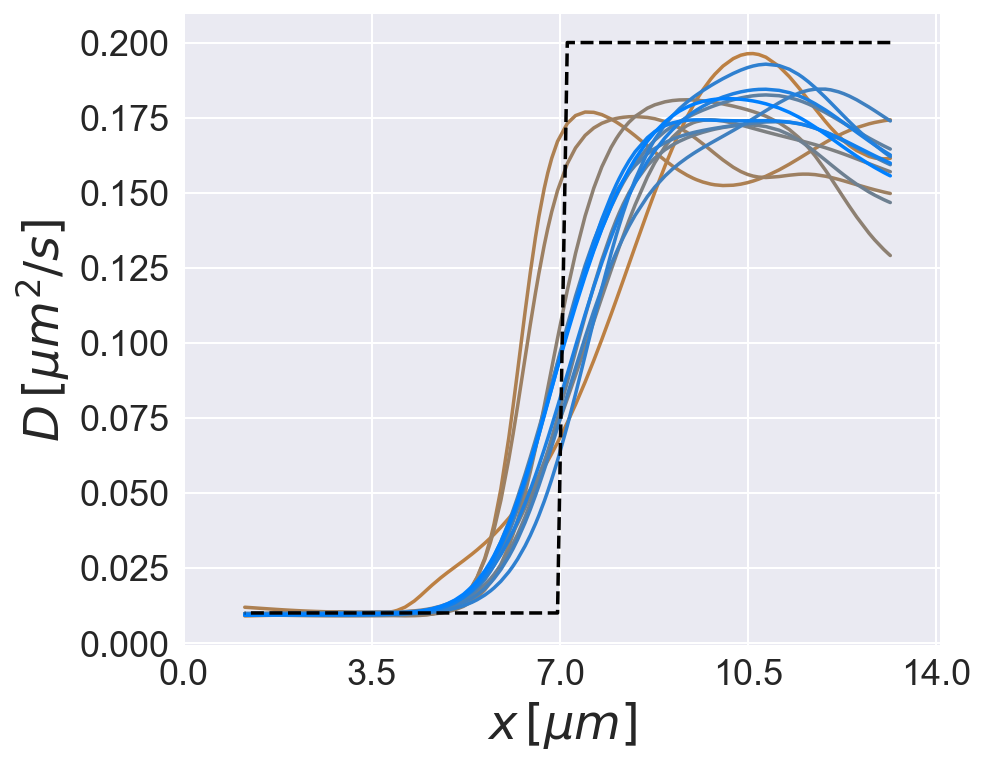

In [27]:
# original KDE
plotTestSetFick()

In [9]:
path = os.path.expanduser('~/Dropbox/Gladfelter_Gems_project/')
savedir = 'net_tracker_testing/synthetic_test_2D/test2D/'
savePath = os.path.join(path, savedir)
print(savePath)

tset = 'trackingData.txt'
jsonfn = os.path.join(savePath, tset)
all_names = []
with open(jsonfn, 'r') as jfile:
    for line in jfile:
        try:
            data = json.loads(line)
        except:
            print(line[:1000])
            badline = line
            continue
        fn = data.keys()[0]
        vdata = data[fn]
#         rfn = os.path.relpath(fn, 'gs://gems-drive/GEMS/' + savedir.split('GEMS-')[1])
#         rfn = os.path.relpath(fn, 'gs://gems-drive/nt-test/test0/')
        rfn = os.path.split(fn)[1]
#         print(rfn)
#         assert False
        subf, nameWithExt = os.path.split(rfn)
        #subf = os.path.join(savePath, subf)
        subf = os.path.split(os.path.split(fn)[0])[1]
        subf = os.path.join('synthetic_tests', subf)
        if 'test2D' in fn:
            subf = os.path.join('synthetic_test_2D', subf)

        if not os.path.isdir(subf):
            os.makedirs(subf)
        #all_names.append(nameWithExt)
        name, ext = os.path.splitext(nameWithExt)
        print(os.path.join(subf, name))

        if not os.path.isdir(savePath):
            os.makedirs(savePath)

        pdata = vdata['particleSet']
        x, y, z = pdata['x'], pdata['y'], pdata['z']
        t, p, r = pdata['t'], pdata['p'], pdata['r']
        Ibg, Ipeak, SNR = pdata['Ibg'], pdata['Ipeak'], pdata['SNR']
        data = array([x, y, z, t, p, r, Ibg, Ipeak, SNR])
        df = pd.DataFrame(
            data.T, 
            columns=['x', 'y', 'z', 't', 'p', 'r', 'Ibg', 'Ipeak', 'SNR'])\
                .astype({'t': 'uint16'})
        if 'test2D' in fn:
            df.z = 8.*1.8
        df.to_csv(os.path.join(subf, name + ' (localizations).csv'))

        #ldata = vdata['tracks']
        #Uparticles = sort(array([int(v) for v in ldata.keys()], 'int'))
        #t, x, y, z, p, r = [], [], [], [], [], []
        #particle = []
        #for pn in Uparticles:
        #    f = ldata[str(pn)]
        #    x.extend(f['x'])
        #    y.extend(f['y'])
        #    z.extend(f['z'])
        #    p.extend(f['p'])
        #    r.extend(f['r'])
        #    t.extend(f['t'])
        #    particle.extend(pn*ones(len(f['x']), 'int'))
        #data = array([particle, t, x, y, z, p, r])
        #df = pd.DataFrame(
        #        data.T, 
        #        columns=['particle', 'frame', 'x', 'y', 'z', 'p', 'r'])\
        #        .astype({'particle': 'int', 'frame': 'int'})\
        #        .sort_values(['particle', 'frame'], axis=0)
        #df.to_csv(os.path.join(subf, name + ' (tracks).csv'))
        #########################
        md = vdata['metadata']
        #c = md['conversions']
        md['dt'] = 0.85
        if 'test3' in fn:
            md['dt'] = 2.
        if 'test5' in fn:
            md['dt'] = 0.3
        
        NF, Ny, Nx, Nz = md['vidShape']
        md['dxy'] = 0.11; md['dz'] = 0.2
        if 'test2D' in fn:
            md['dz'] = 0.11
            md['dt'] = 0.03
        print(NF, Ny, Nx, Nz)
        outdict = {'Seq_NF': array([u'Real Number'], dtype='<U11'),
                   'Seq_Nx': array([u'Real Number'], dtype='<U11'),
                   'Seq_Ny': array([u'Real Number'], dtype='<U11'),
                   'Seq_Nz': array([u'Real Number'], dtype='<U11'),
                   'Seq_dxy': array([u'Real Number'], dtype='<U11'),
                   'Seq_dz': array([u'Real Number'], dtype='<U11'),
                   'Seq_dt': array([u'Real Number'], dtype='<U11'),
                   'NF': array([[NF]], dtype='int32'),
                   'Nx': array([[Nx]], dtype='int32'),
                   'Ny': array([[Ny]], dtype='int32'),
                   'Nz': array([[Nz]], dtype='int32'),
                   'dxy': array([[md['dxy']]], dtype='float32'),
                   'dz': array([[md['dz']]], dtype='float32'),
                   'dt': array([[md['dt']]], dtype='float32')}
        savemat(os.path.join(subf, name + '-videoMetaData.mat'), outdict, format='4')

/Users/jaynewby/Dropbox/Gladfelter_Gems_project/net_tracker_testing/synthetic_test_2D/test2D/
synthetic_test_2D/synthetic_tests/test2D_2/4
100 128 128 1
synthetic_test_2D/synthetic_tests/test2D_2/8
100 128 128 1
synthetic_test_2D/synthetic_tests/test2D_2/3
100 128 128 1
synthetic_test_2D/synthetic_tests/test2D_2/7
100 128 128 1
synthetic_test_2D/synthetic_tests/test2D_2/2
100 128 128 1
synthetic_test_2D/synthetic_tests/test2D_2/5
100 128 128 1
synthetic_test_2D/synthetic_tests/test2D_2/6
100 128 128 1
synthetic_test_2D/synthetic_tests/test2D_2/9
100 128 128 1
synthetic_test_2D/synthetic_tests/test2D_2/0
100 128 128 1
synthetic_test_2D/synthetic_tests/test2D_2/1
100 128 128 1


In [3]:
### HYPHA GEOMETRY FILES
tn = 'synthetic_tests_gt/test6b' + 'gt'
with open('./surface and axis.dtbin', mode='rb') as sfile:
    s = sfile.read()
for n in arange(28):
    with open(os.path.join('./'+tn, str(n) + '-hyphaeList-withSkeletons.dtbin'), mode='w+b') as sfile:
        sfile.write(s)
    

In [2]:
### SAVE MAX PROJECTIONS
# tn = 'synthetic_tests/test4b'
tn = 'synthetic_test_2D/test2D'
for n in arange(10):
    with tf.gfile.Open(
        tn + '/{0}.dat'.format(n), 
        mode='rb') as dfile:
        d = pickle.load(dfile)
        tifg.imsave(tn + '/{0}.nd2.tif'.format(n), d['vid'].max(axis=3))
        #tifg.imsave('synthTest/{0}-full.tif'.format(n), d['vid'].transpose(0, 3, 1, 2))

In [ ]:
# files = getFiles('test', 'dat')
# allData = {}
# for fn in files:
#     path, name = os.path.split(fn)
#     with open(fn+'.dat', 'rb') as dfile:
#         d = pickle.load(dfile)
#         r = d['Nz']*1.8/2.
#         vol = 2.*pi*r**2*d['Nx']
#         toSave = dict(
#             (k, d[k]) for k in d if not k in ['vid'])
#         toSave['SNR'] = d['pamp'] /d['kappa']
#         toSave['ParticleDensity'] = d['Nparticles']/vol
#         toSave['dxy'] = 0.11
#         toSave['dt'] = 0.65
#         toSave['dz'] = 0.2
#         toSave['D'] = (0.4, 6.)
#         allData[int(name)] = toSave
# with open('synthTest1/synthTest1_truth_Data.pickle', 'w+b') as sfile:
#     pickle.dump(allData, sfile)

In [10]:
### GROUND TRUTH TRACKS
# tn = 'synthetic_tests/test6b'
tn = 'synthetic_test_2D/test2D'
files = getFiles(tn, 'dat')
for fn in files:
    path, name = os.path.split(fn)
    with open(fn+'.dat', 'rb') as dfile:
        dat = pickle.load(dfile)
    ## 'x, y, z, t, particle, r, segment'
    tracks = dat['tracks']
    tracks[..., 2] = 8.*1.8
    Nparticles = tracks.shape[1]
    Nt = tracks.shape[0]
    out = zeros((Nt*Nparticles, 7))
    for pn in arange(Nparticles):
        out[pn*Nt: (pn+1)*Nt, :] = c_[
            tracks[:, pn, :], #xyz
            arange(Nt),           #t
            pn*ones((Nt, 1)), #particle
            zeros((Nt, 1)),   #radius
            ones((Nt, 1))]    #segment
    df = pd.DataFrame(out, columns=['x', 'y', 'z', 't', 'particle', 'r', 's'])
    df.to_csv(fn+' (ground truth tracks).csv', index=False)
    fn2 = os.path.join('synthetic_tests_gt/', os.path.split(tn)[1] + 'gt')
    fn2 = os.path.join(fn2, os.path.split(fn)[1]) 
    try:
        os.makedirs(os.path.split(fn2)[0])
    except:
        pass
    df.to_csv(fn2+' (ground truth tracks).csv', index=False)

Total number of dat files:  10


In [ ]:
### Video Metadata files
tn = 'synthetic_tests/test6b'
files = getFiles(tn, 'mat')
for fn in files:
    print(fn)
    with open(fn+'.mat', 'rb') as dfile:
        d = dfile.read()
    fn2 = os.path.join('synthetic_tests_gt/', os.path.split(tn)[1] + 'gt')
    fn2 = os.path.join(fn2, os.path.split(fn)[1]) 
    with open(fn2+'.mat', 'w+b') as sfile:
        sfile.write(d)

(200, 205, 3)

In [23]:
dxy**2/dt*(diff(tracks, axis=0)**2).sum()/200./2./3./205

0.008319535726028216

## 

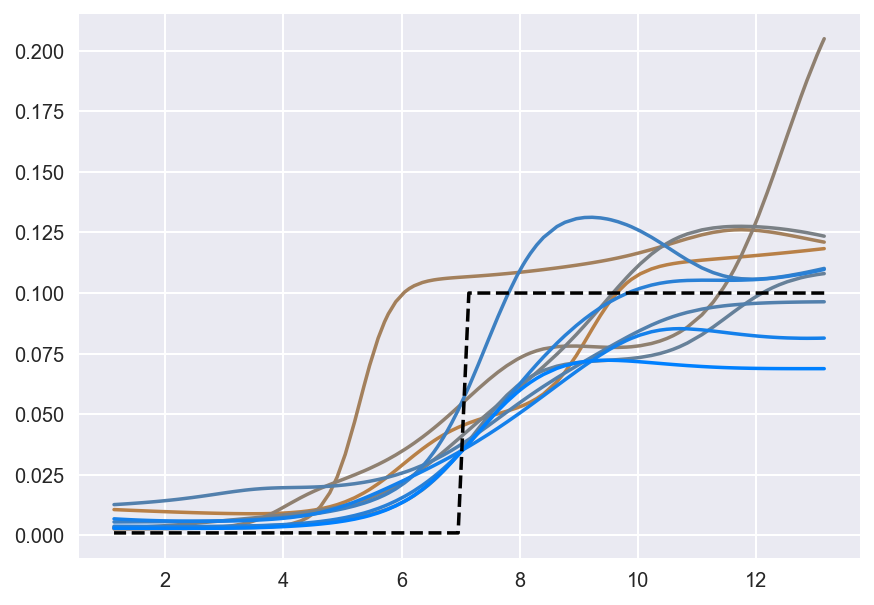

In [22]:
figure(1, [7, 5])
afn0 = '../Axial_Projections/net_tracker_testing (axialDensityData)/synthetic_test_2D/test2D/'
dxy = 0.11
dt = 0.03
D0 = (0.001, 0.1)
Nvids = 10
I = arange(0, Nvids, 1)
# I = arange(0, 5)
N = I.size
colors = 0.8*(arange(1.*N)/N)[::-1]
for n, c in zip(I, colors):
    afn = afn0 + '{0}-hyphaAxisDensity.dtbin'.format(n)
    with DTDataFile(afn, readonly=True) as sfile:
        #print(sfile.variable_names())
        if array(sfile['Var_0_arcLength']).size <= 1:
            continue
        AL = array(sfile['Var_0_arcLength']).squeeze()
        ALxyz = array(sfile['Var_0_axisPosition']).squeeze()
        avg_D = array(sfile['Var_0_diffusivity']).squeeze()
        min_proj_D = array(sfile['Var_0_minProjection']).squeeze()
    plot(
        dxy*ALxyz[0], 
        dxy**2/dt*avg_D[:, -1], 
        color=(c, .5, 1-c), 
        #label='{0:0.2g} $/\mu m^3$'.format(NP.flatten()[n]/vol)
    )
sy = D0[1]*ones(ALxyz[0].size)
sy[ALxyz[0] < 64] = D0[0]
plot(dxy*ALxyz[0], sy, '--k')

In [48]:
def plotTestSet(nset, ax=None, kind='A', m=1):
    assert 1 <= nset <= 6
    Nvids = 104 if nset <= 1 else 20
    step = 5 if nset <= 1 else 2
    assert 0 <= m < step
    timings = [0.85, 0.85, 2., 0.85, 0.3, 0.85]
    if ax == None:
        fig1 = figure(1, [12, 5])
        ax1 = fig1.add_subplot(121)
        ax2 = fig1.add_subplot(122)
    else:
        ax1, ax2 = ax
    dxy = 0.11
    dt = timings[nset-1]
    if nset == 1:
        kind = 'B'
        D0 = dxy**2/dt*array([0.4, 6])
        PAMP, NP = meshgrid(
            linspace(2, 100, 20),
            arange(5, 70, 10))
    elif nset == 2:
        D0 = array([0.01, 0.1])
        PAMP, NP = meshgrid(
            [25., 33.75],
            [5, 10, 15, 20, 25, 45, 65, 85, 105, 125, 145, 165, 185, 205])
    else:
        if nset in [3, 4, 5]:
            D0 = array([0.01, 0.2])
        if nset == 6:
            D0 = array([0.001, 0.02])
        PAMP, NP = meshgrid(
            [25., 33.75],
            [5, 10, 15, 20, 25, 45, 65, 85, 105, 125, 145, 165, 185, 205])
    r = 17*1.8/2.*dxy
    L = 128*dxy
    vol = 2.*pi*r**2*L
    def plotSet(m, gt=False):
        I = arange(m, Nvids, step)
        # I = arange(0, 5)
        N = I.size
        colors = 0.8*(arange(1.*N)/N)[::-1]
        for n, c in zip(I, colors):
            afn = afn0 + '{0}-hyphaAxisDensity.dtbin'.format(n)
            with DTDataFile(afn, readonly=True) as sfile:
                #print(sfile.variable_names())
                if array(sfile['Var_0_arcLength']).size <= 1:
                    continue
                AL = array(sfile['Var_0_arcLength']).squeeze()
                ALxyz = array(sfile['Var_0_axisPosition']).squeeze()
                avg_D = array(sfile['Var_0_diffusivity']).squeeze()
                min_proj_D = array(sfile['Var_0_minProjection']).squeeze()
            plot(
                dxy*ALxyz[0], 
                dxy**2/dt*avg_D[:, -1], 
                color=(c, .5, 1-c), 
                label='{0:0.2g} $/\mu m^3$'.format(NP.flatten()[n]/vol))
            
        if kind == 'A':
            sy = D0[1]*ones(ALxyz[0].size)
            sy[ALxyz[0] < 64] = D0[0]
        else:
            sy = D0[1]*ones(ALxyz[0].size)
            plot(dxy*ALxyz[0], sy, '--k')
            s = linspace(51, 77)
            p = 0.25#0.5**2/(0.5**2 + D0[0]/D0[1])
            plot(dxy*s, (D0[0]*p + D0[1]*(1-p))*ones(s.size), '--r')#, label='volume average')
            plot(dxy*s, D0[0]*ones(s.size), '--k')
        plot(dxy*ALxyz[0], sy, '--k')
        xticks([0, 3.5, 7, 10.5, 14], fontsize=18)
        #yticks([0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24], fontsize=18)
        yticks(fontsize=18)
        xlim(0, dxy*128)
        if m == 0:
            ylim(0, D0[1]*1.4)
        else:
            ylim(0, D0[1]*1.4)
        xlabel('$x\, [\mu m]$', fontsize=24);
        ylabel('$D\, [\mu m^2/s]$', fontsize=24);
        if gt:
            pass
            #title('ground truth tracking'.format(dt), fontsize=20)
        else:
            title('{0:0.2g}s per stack'.format(dt), fontsize=20)
    #############################################
    path1 = '../Axial_Projections/net_tracker_testing (axialDensityData)/'
    if kind == 'B' and nset > 1:
        afn0 = path1 + 'synthetic_tests/test{0}b/'.format(nset)
    else:
        afn0 = path1 + 'synthetic_tests/test{0}/'.format(nset)
    #############################################
    #ax1 = fig1.add_subplot(121)
    sca(ax1)
    plotSet(m, False)
    #############################################
    if kind == 'B' and nset > 1:
        afn0 = path1 + 'synthetic_tests_gt/test{0}bgt/'.format(nset)
    else:
        afn0 = path1 + 'synthetic_tests_gt/test{0}gt/'.format(nset)
    #############################################
    #ax2 = fig1.add_subplot(122)
    sca(ax2)
    plotSet(m, True)
#     sca(ax1)
#     legend(fontsize=10, ncol=1, loc='upper left')
    if nset == 6:
        subplots_adjust(left=0.1, bottom=0.16, right=0.97, wspace=0.3)
    else:
        subplots_adjust(left=0.09, bottom=0.16, right=0.97, wspace=0.3)
    
#     draw();
#     if kind == 'A':
#         if m > 0:
#             savefig('fig_test_{0}.pdf'.format(nset))
#             savefig('fig_test_{0}.png'.format(nset), dpi=300)
#         else:
#             savefig('fig_test_{0} (low SNR).pdf'.format(nset))
#             savefig('fig_test_{0} (low SNR).png'.format(nset), dpi=300)
#     show();
    
    
    
#0.25    
# plotTestSet(2, m=0)
# plotTestSet(2, m=1)

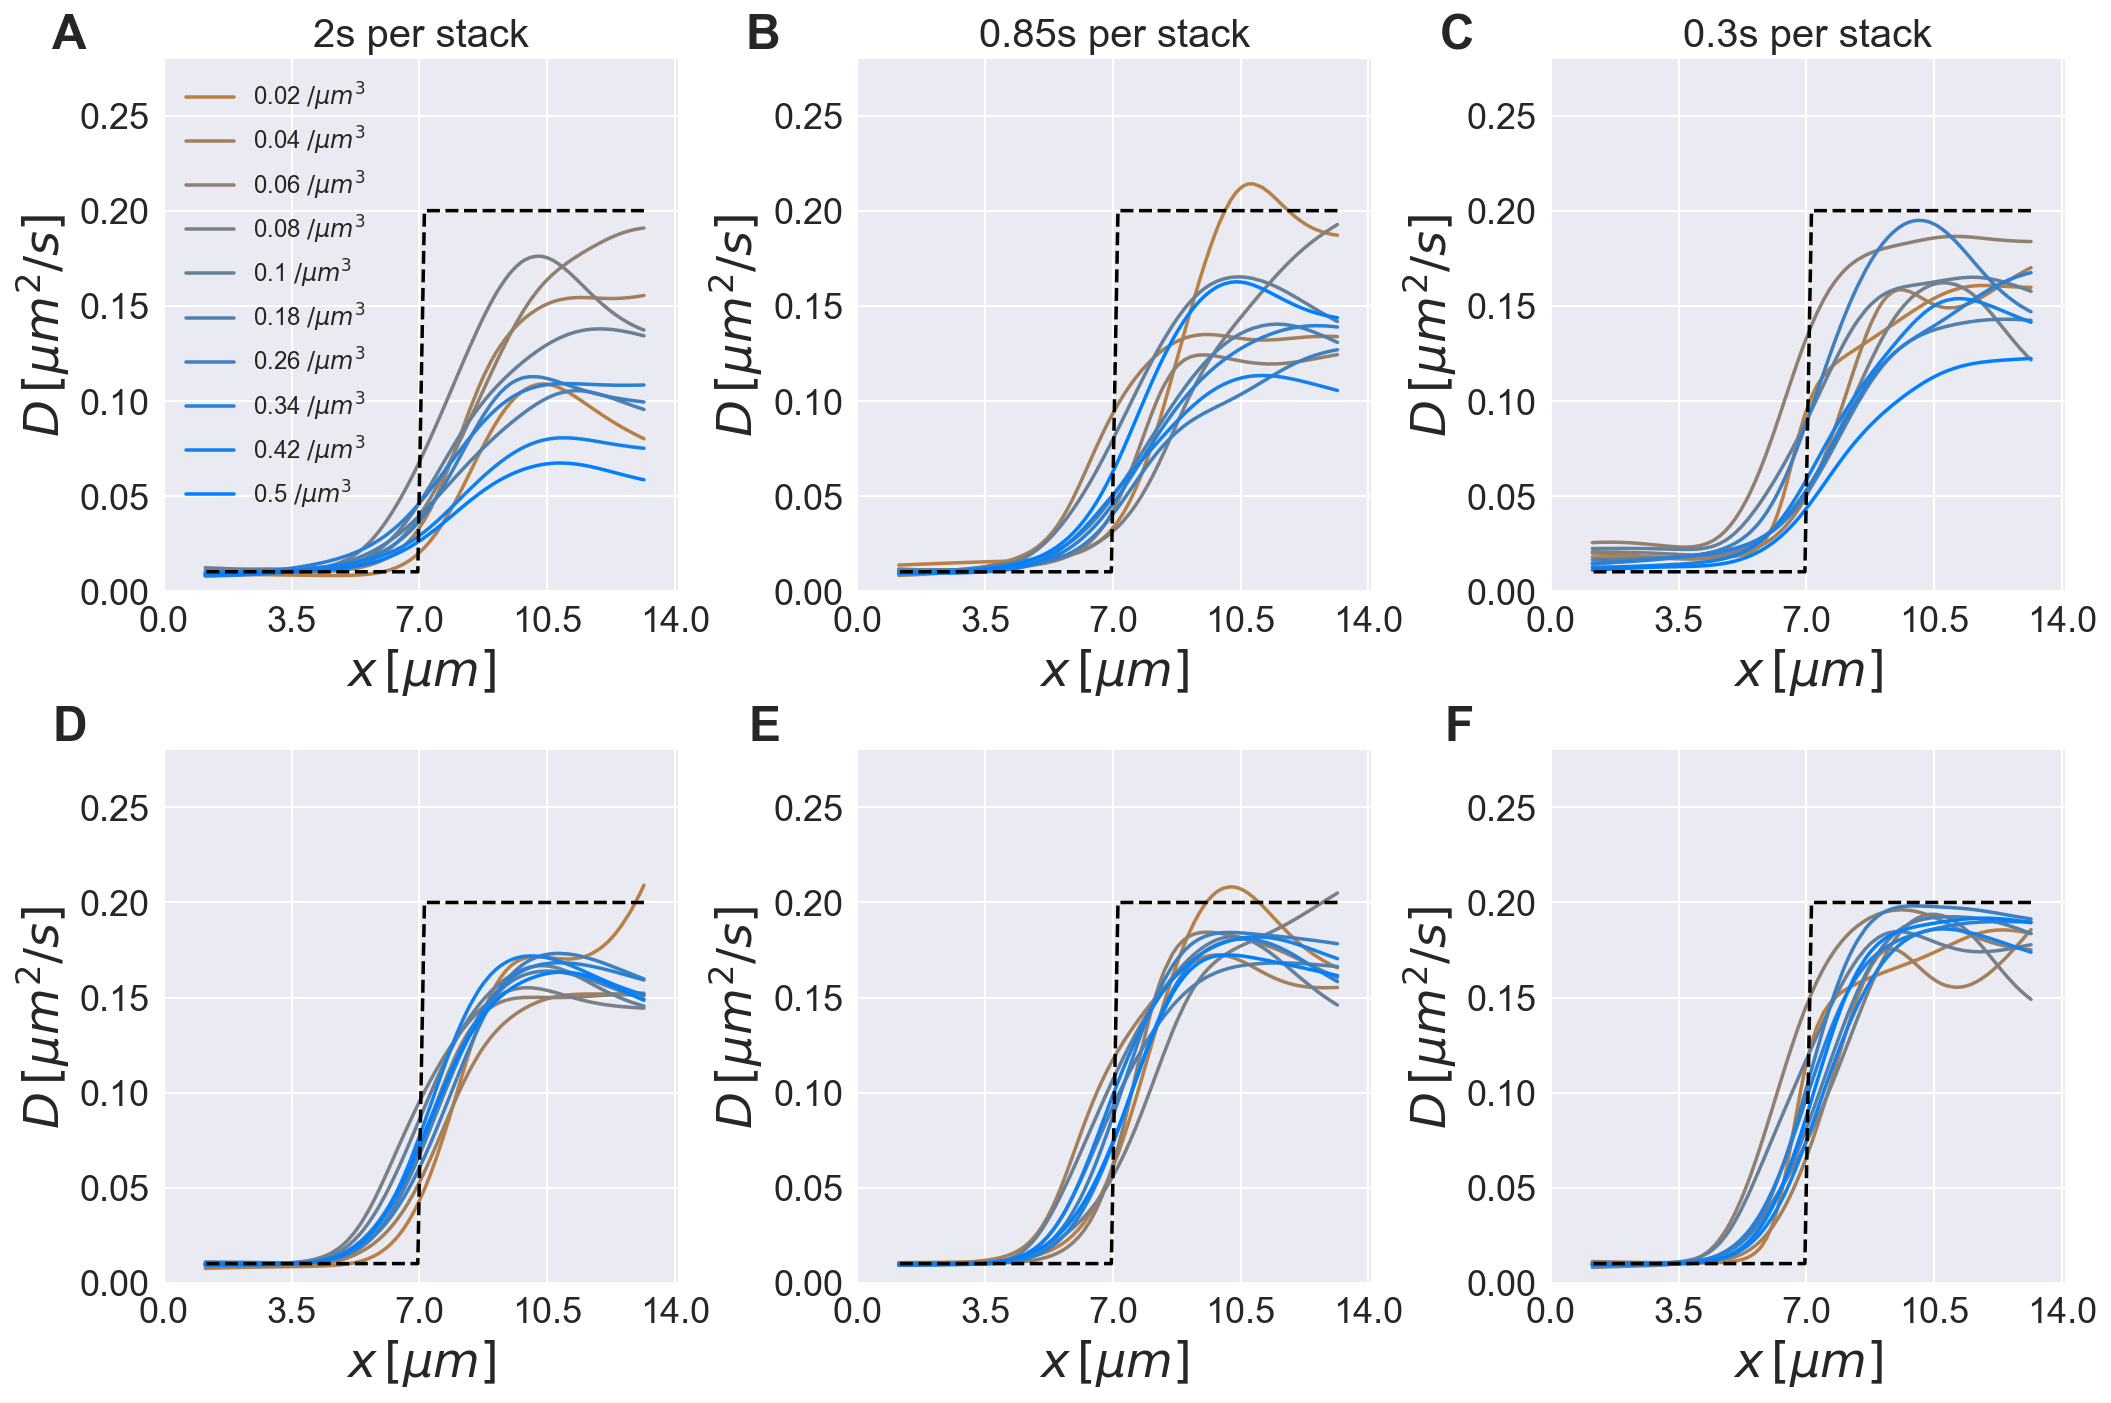

In [63]:
fig1 = figure(1, [15, 10])
labeler = makeFigLabeler(offset=0.15)
ax11 = fig1.add_subplot(231)
ax12 = fig1.add_subplot(234)
ax21 = fig1.add_subplot(232)
ax22 = fig1.add_subplot(235)
ax31 = fig1.add_subplot(233)
ax32 = fig1.add_subplot(236)
plotTestSet(3, ax=[ax11, ax12], m=1)
plotTestSet(4, ax=[ax21, ax22], m=1)
plotTestSet(5, ax=[ax31, ax32], m=1)
ax11.legend(fontsize=12, ncol=1, loc='upper left')
labeler(ax11)
labeler(ax21)
labeler(ax31)
labeler(ax12)
labeler(ax22)
labeler(ax32)
subplots_adjust(hspace=0.3, wspace=0.35, bottom=0.1, top=0.95)
savefig('test1_combined.pdf')

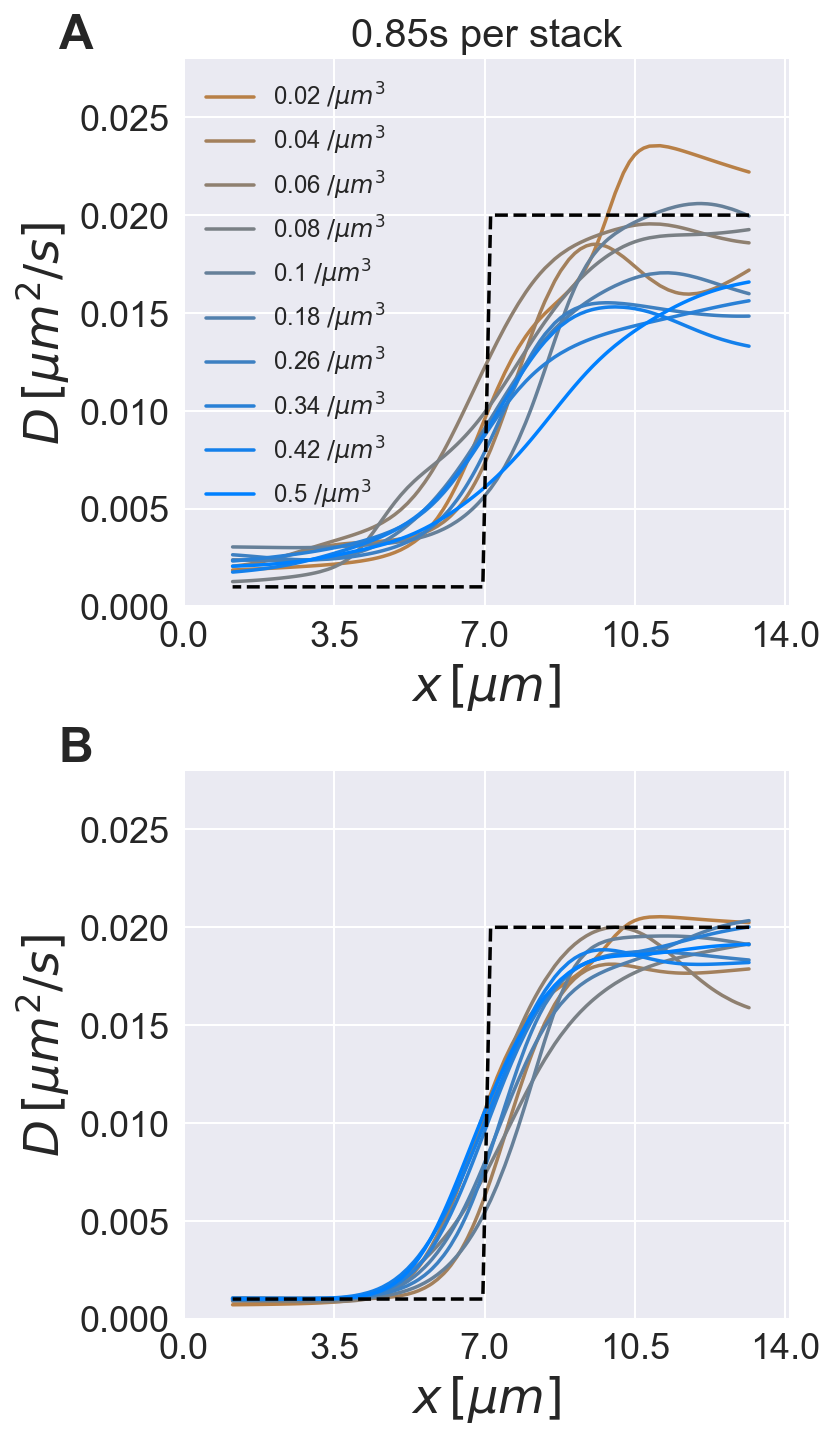

In [64]:
fig1 = figure(1, [6, 10])
labeler = makeFigLabeler(offset=0.15)
ax1 = fig1.add_subplot(211)
ax2 = fig1.add_subplot(212)
plotTestSet(6, ax=[ax1, ax2], m=1)
ax1.legend(fontsize=12, ncol=1, loc='upper left')
labeler(ax1)
labeler(ax2)
subplots_adjust(hspace=0.3, left=0.2, right=0.9, bottom=0.075, top=0.95)
savefig('test2_combined.pdf')

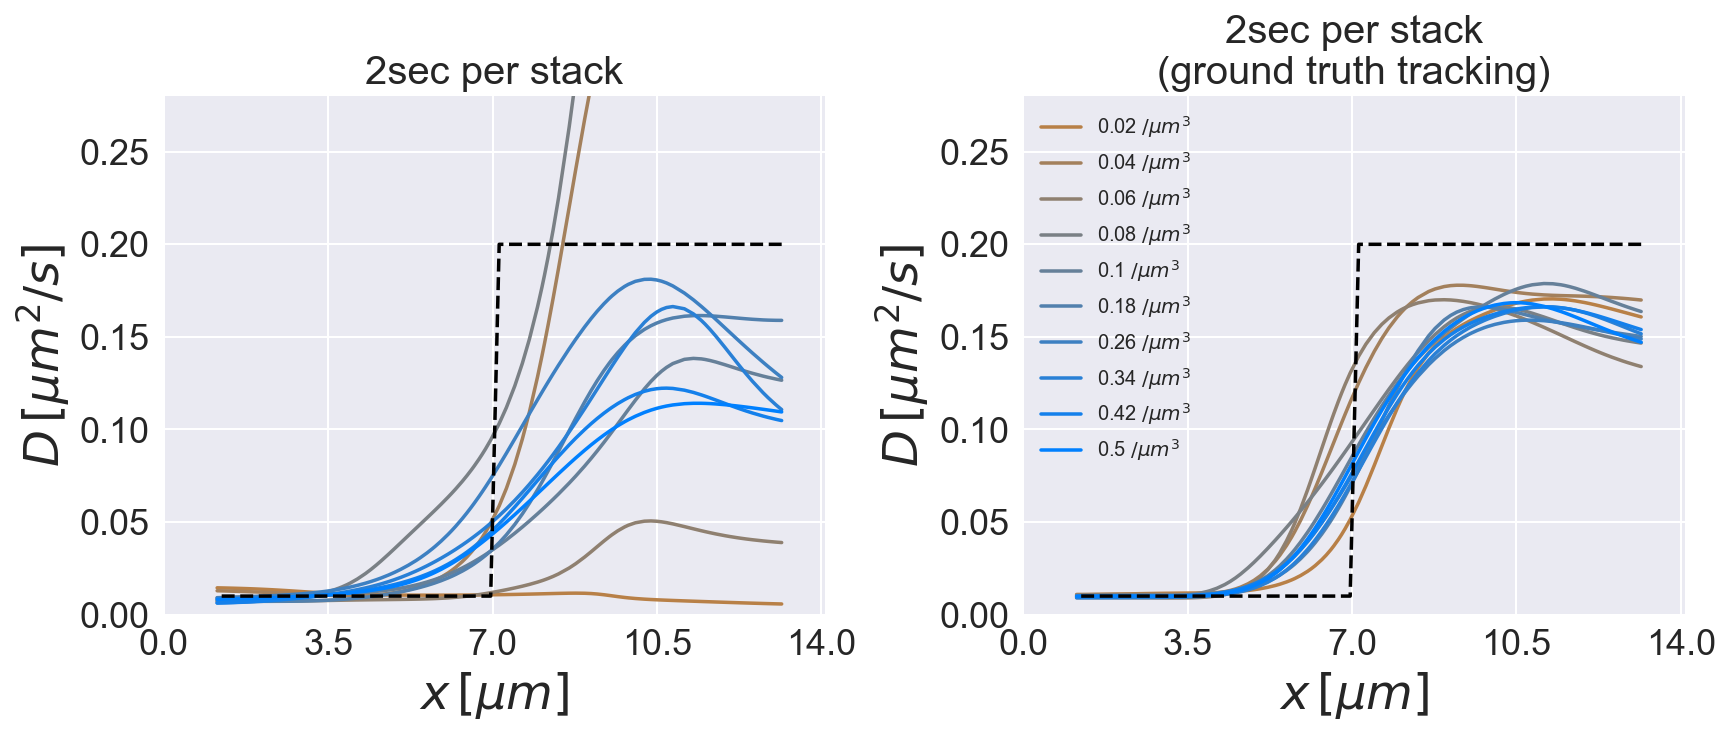

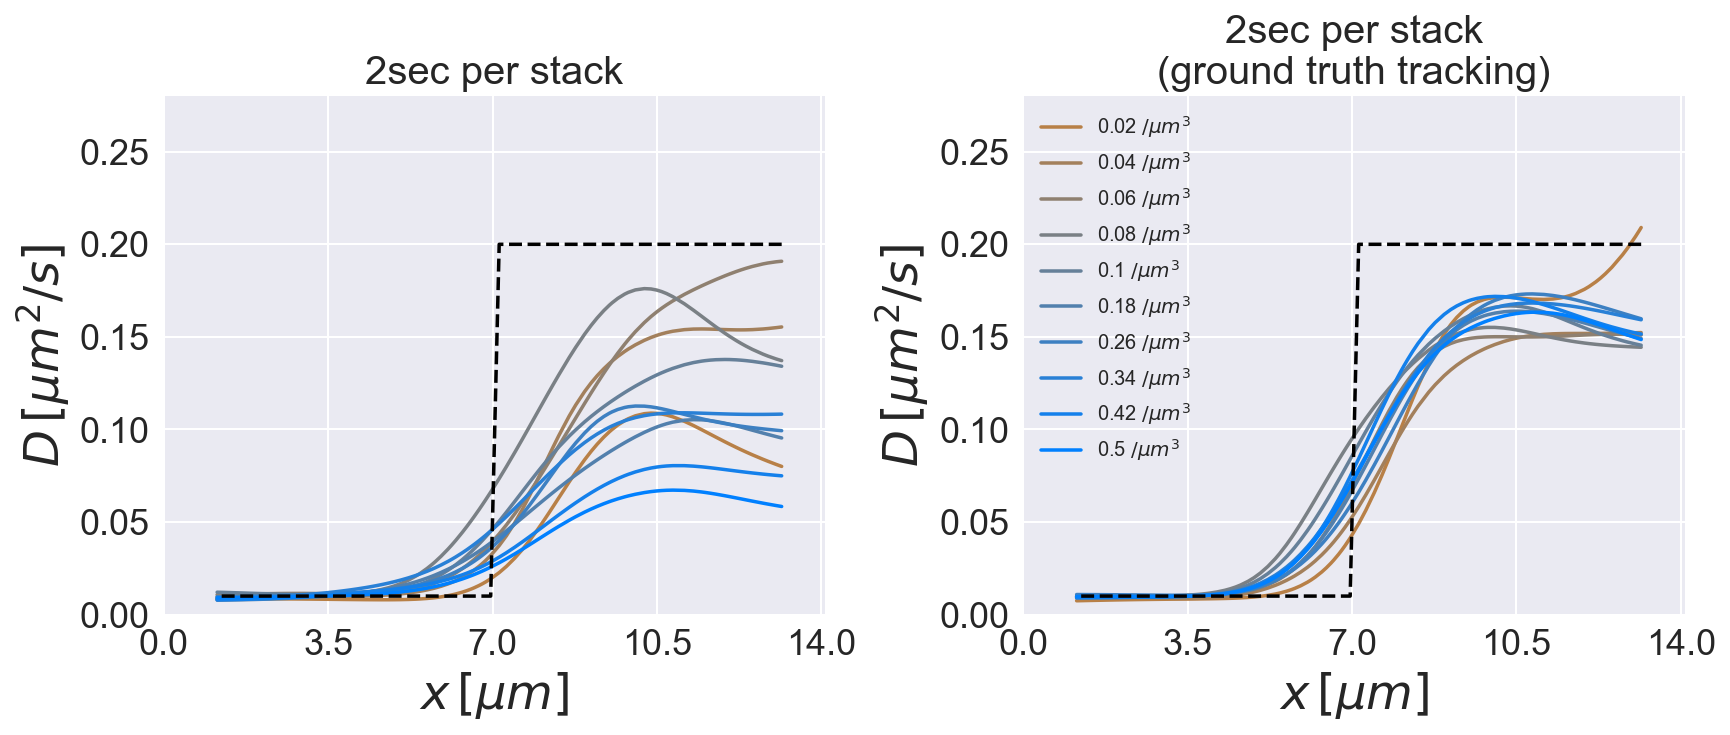

In [148]:
# 0.45 max
plotTestSet(3, m=0)
plotTestSet(3, m=1)

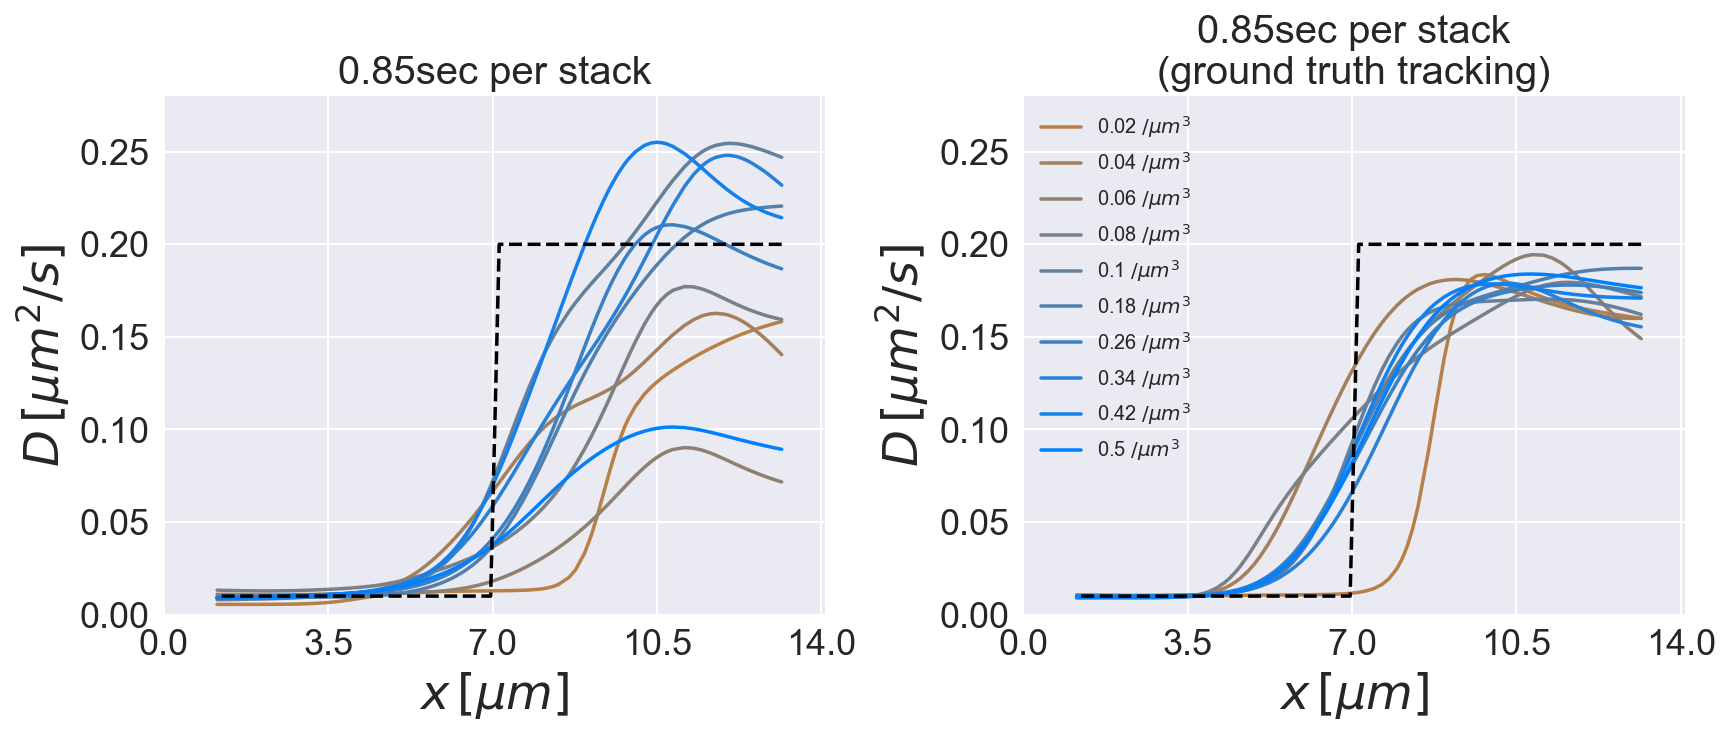

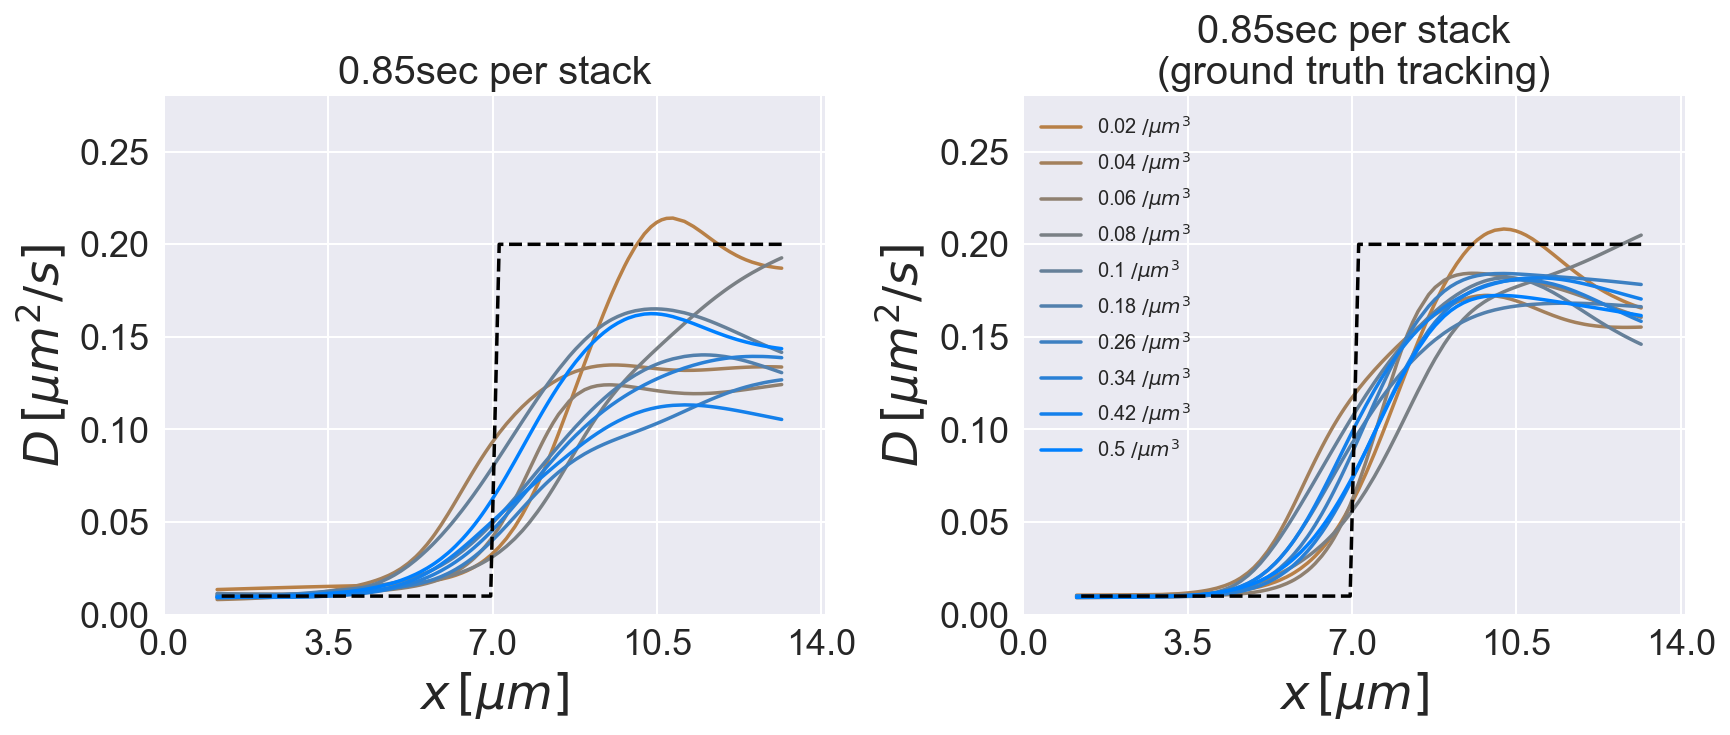

In [149]:
#0.35 max
plotTestSet(4, m=0)
plotTestSet(4, m=1)

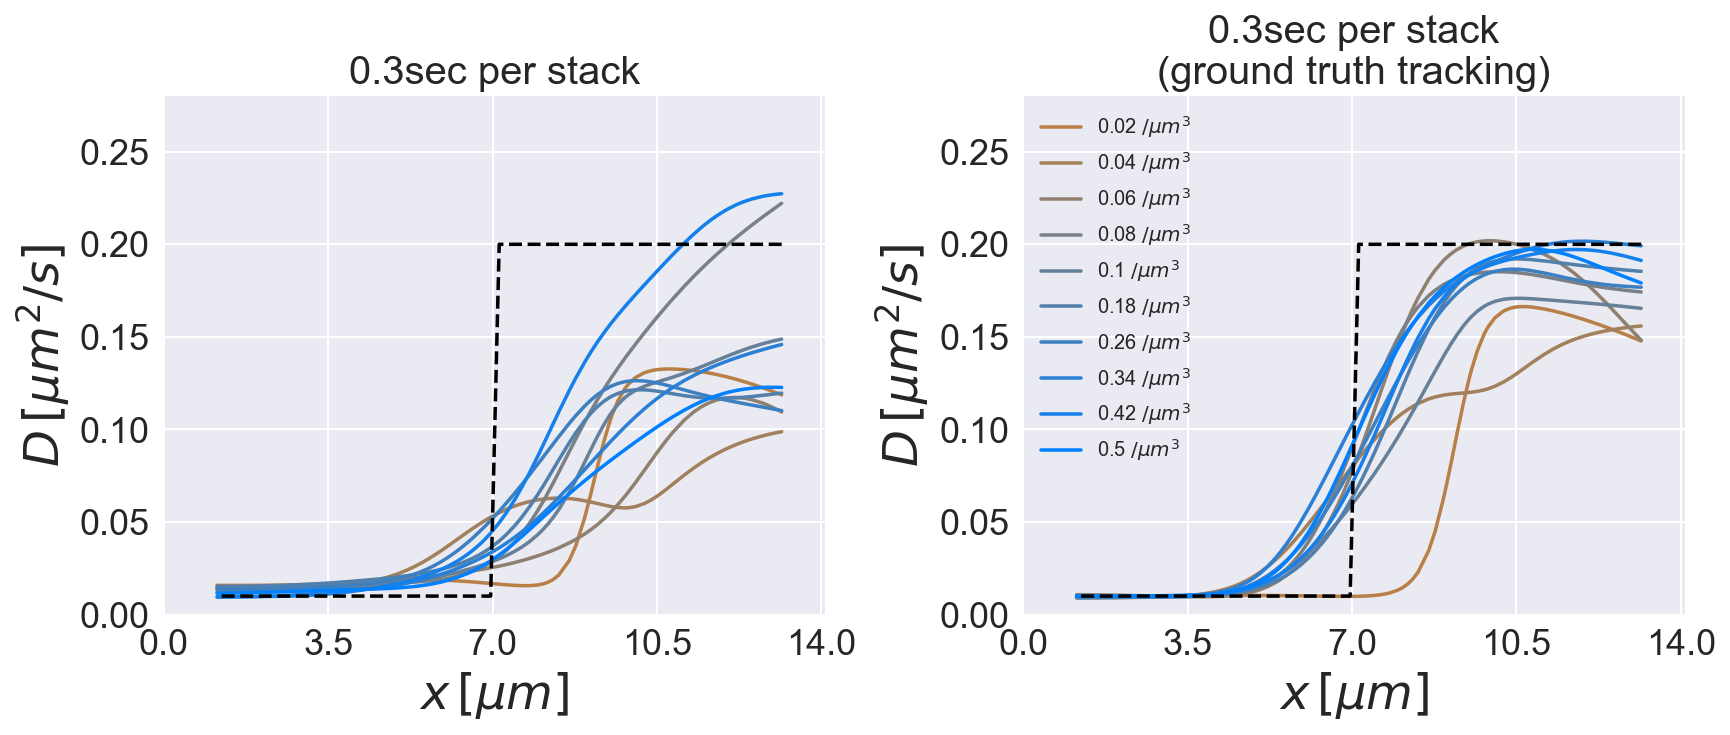

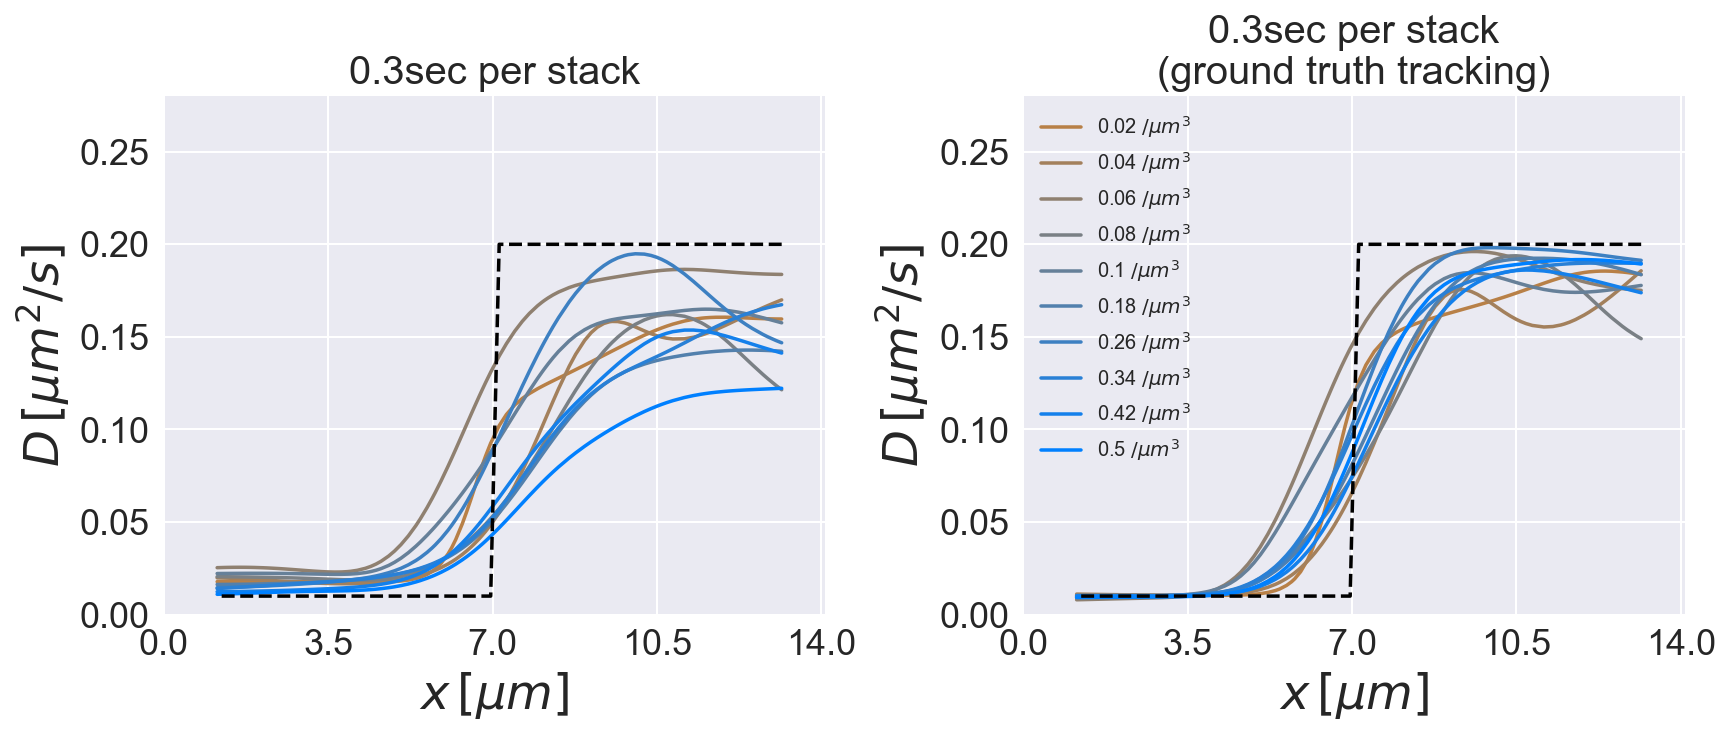

In [150]:
plotTestSet(5, m=0)
plotTestSet(5, m=1)

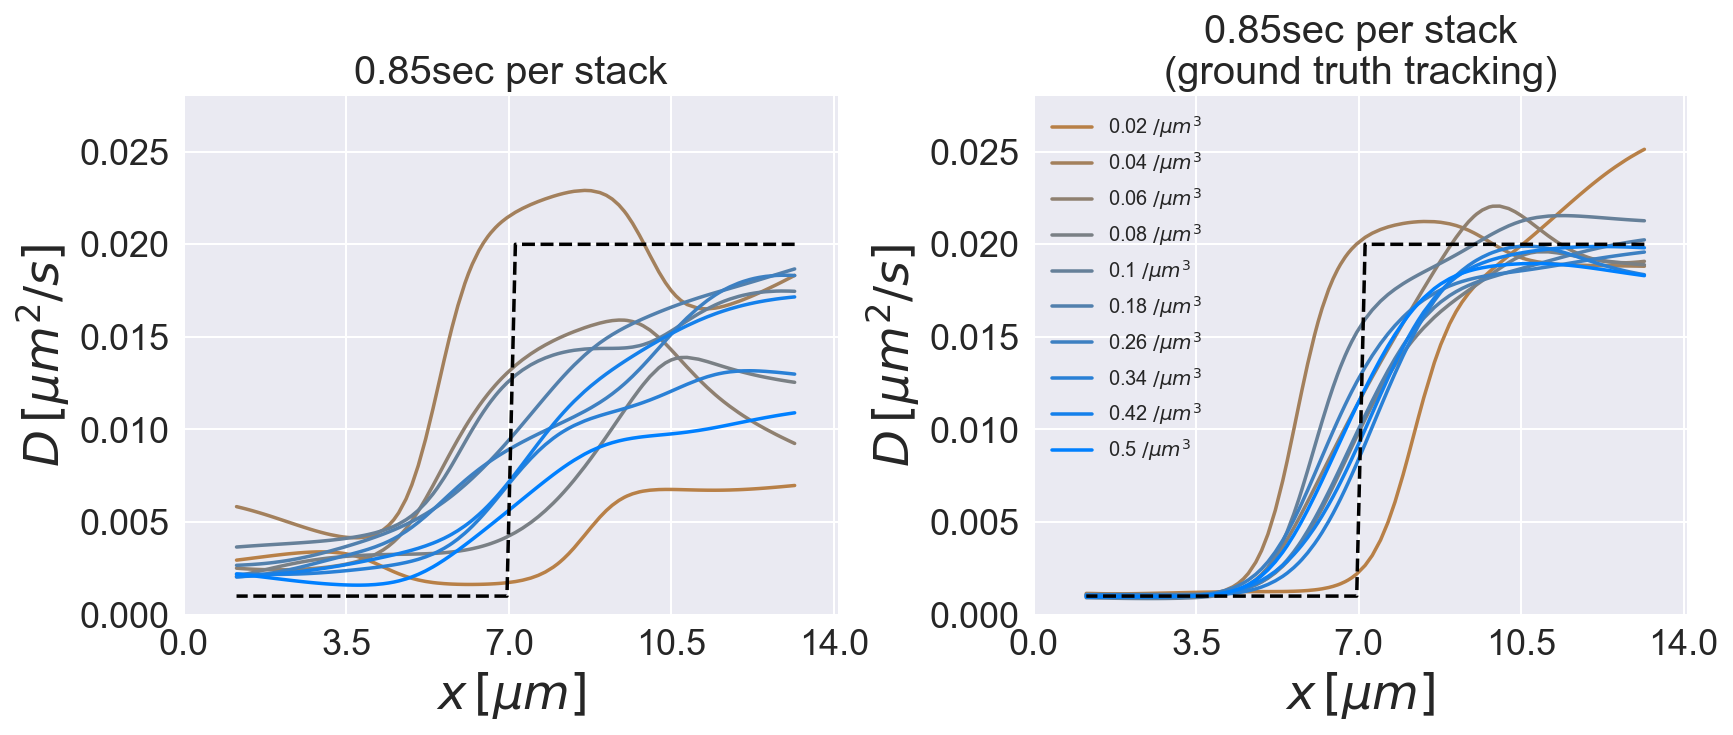

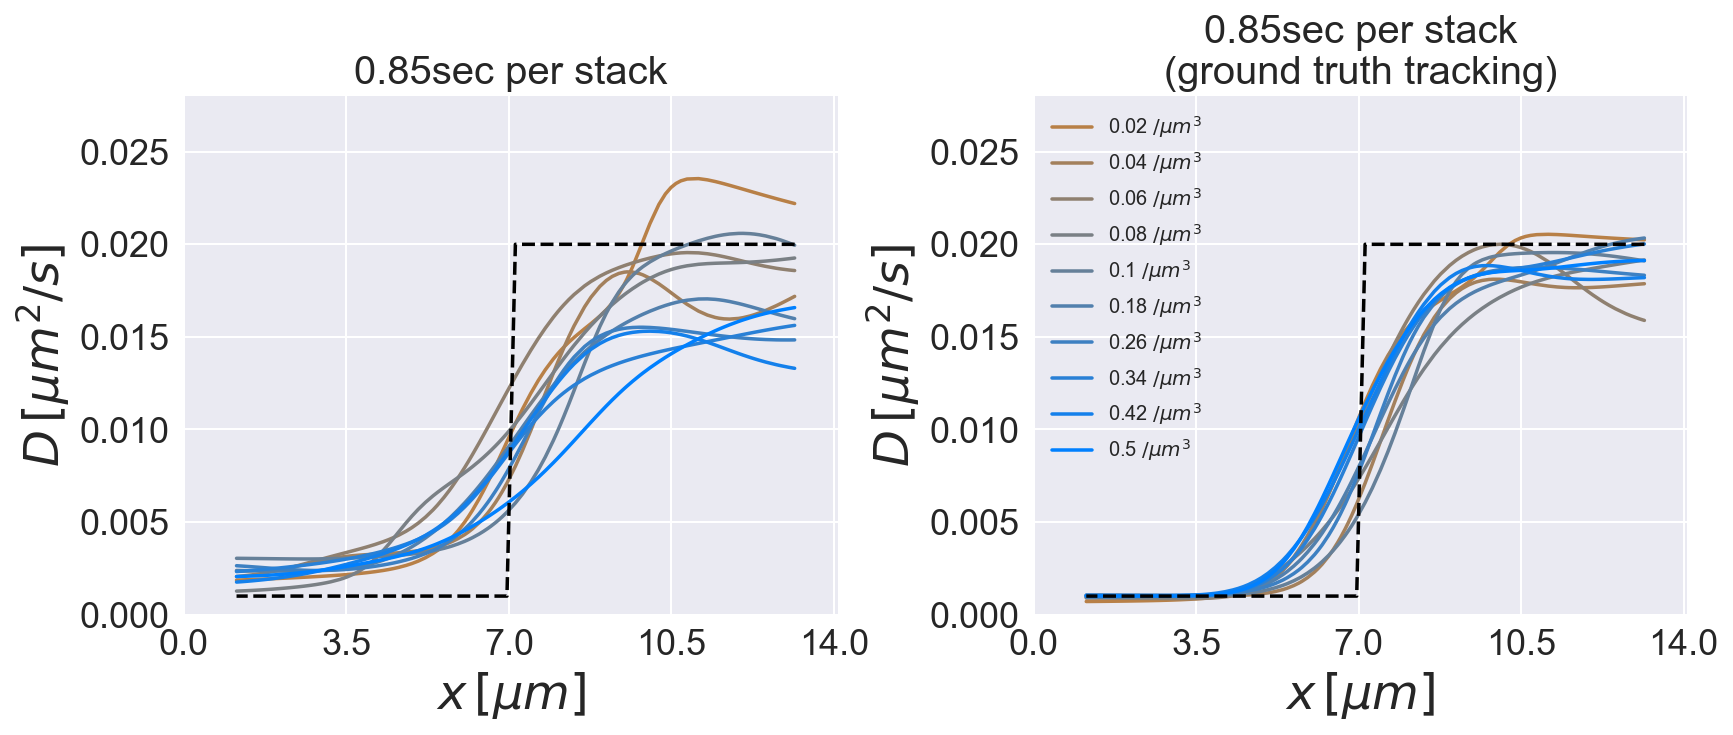

In [151]:
plotTestSet(6, m=0)
plotTestSet(6, m=1)

# ##

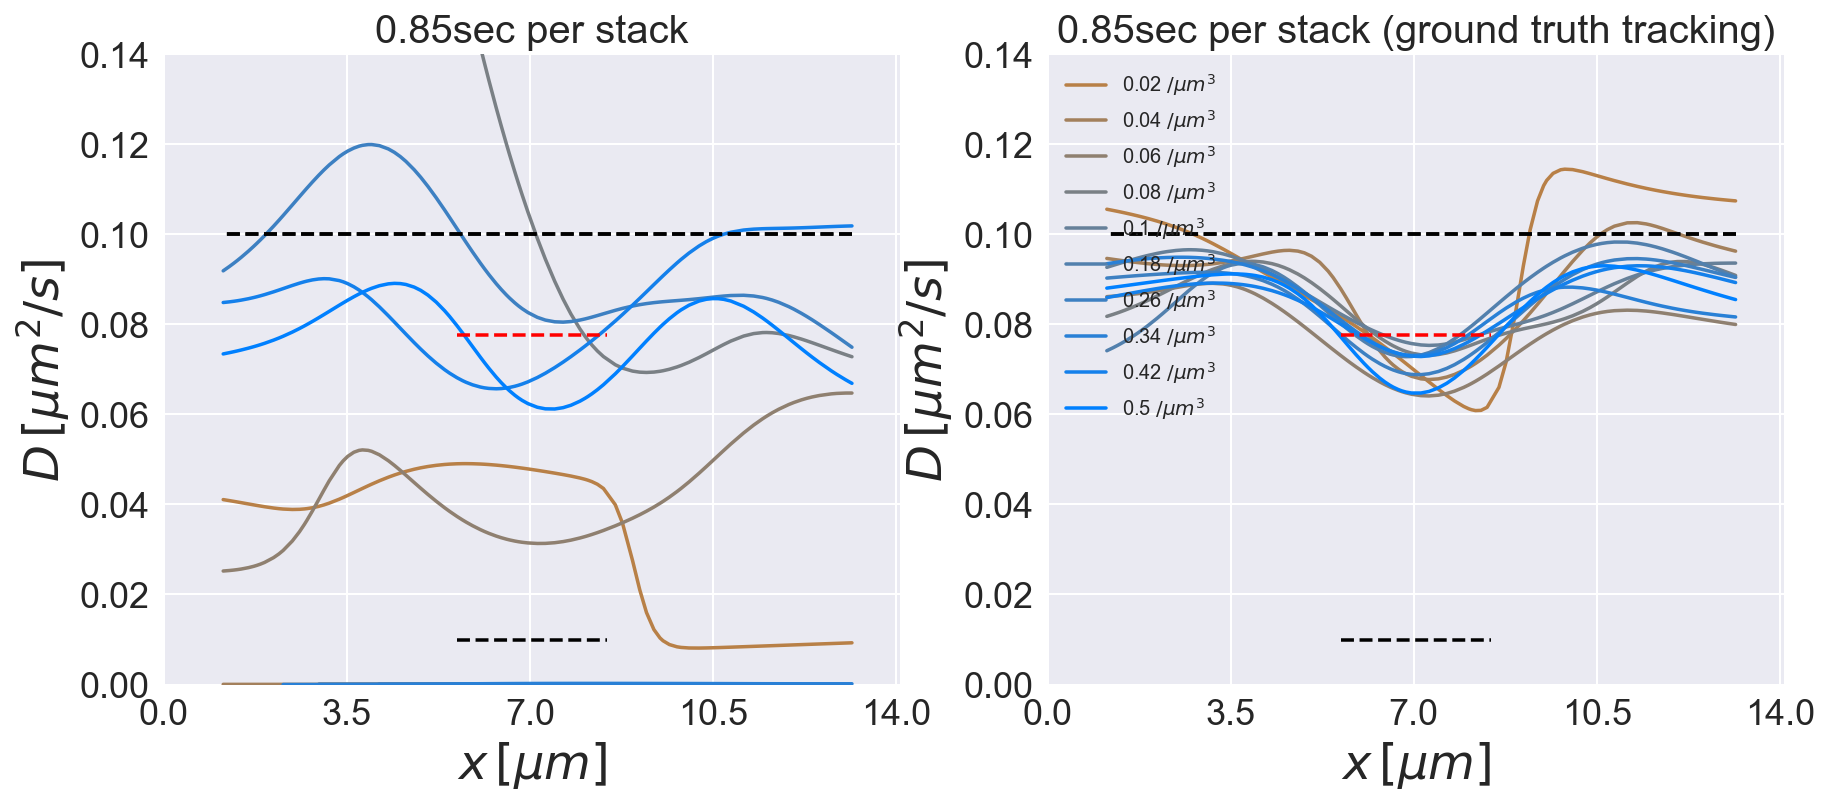

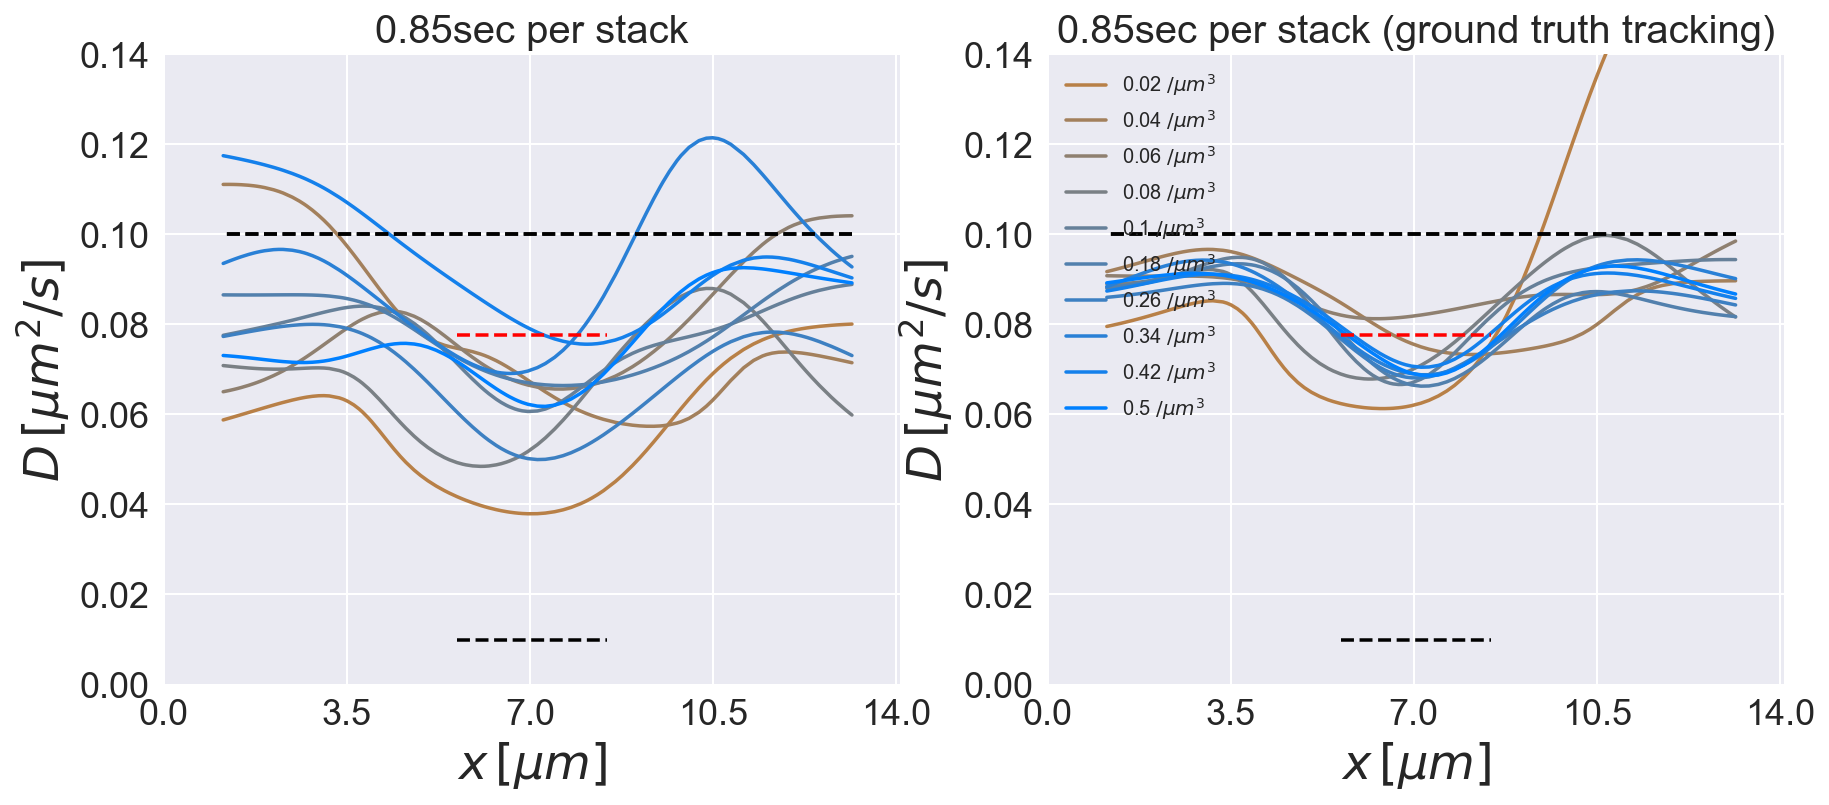

In [7]:
#0.3
plotTestSet(2, m=0, kind='B')
plotTestSet(2, m=1, kind='B')

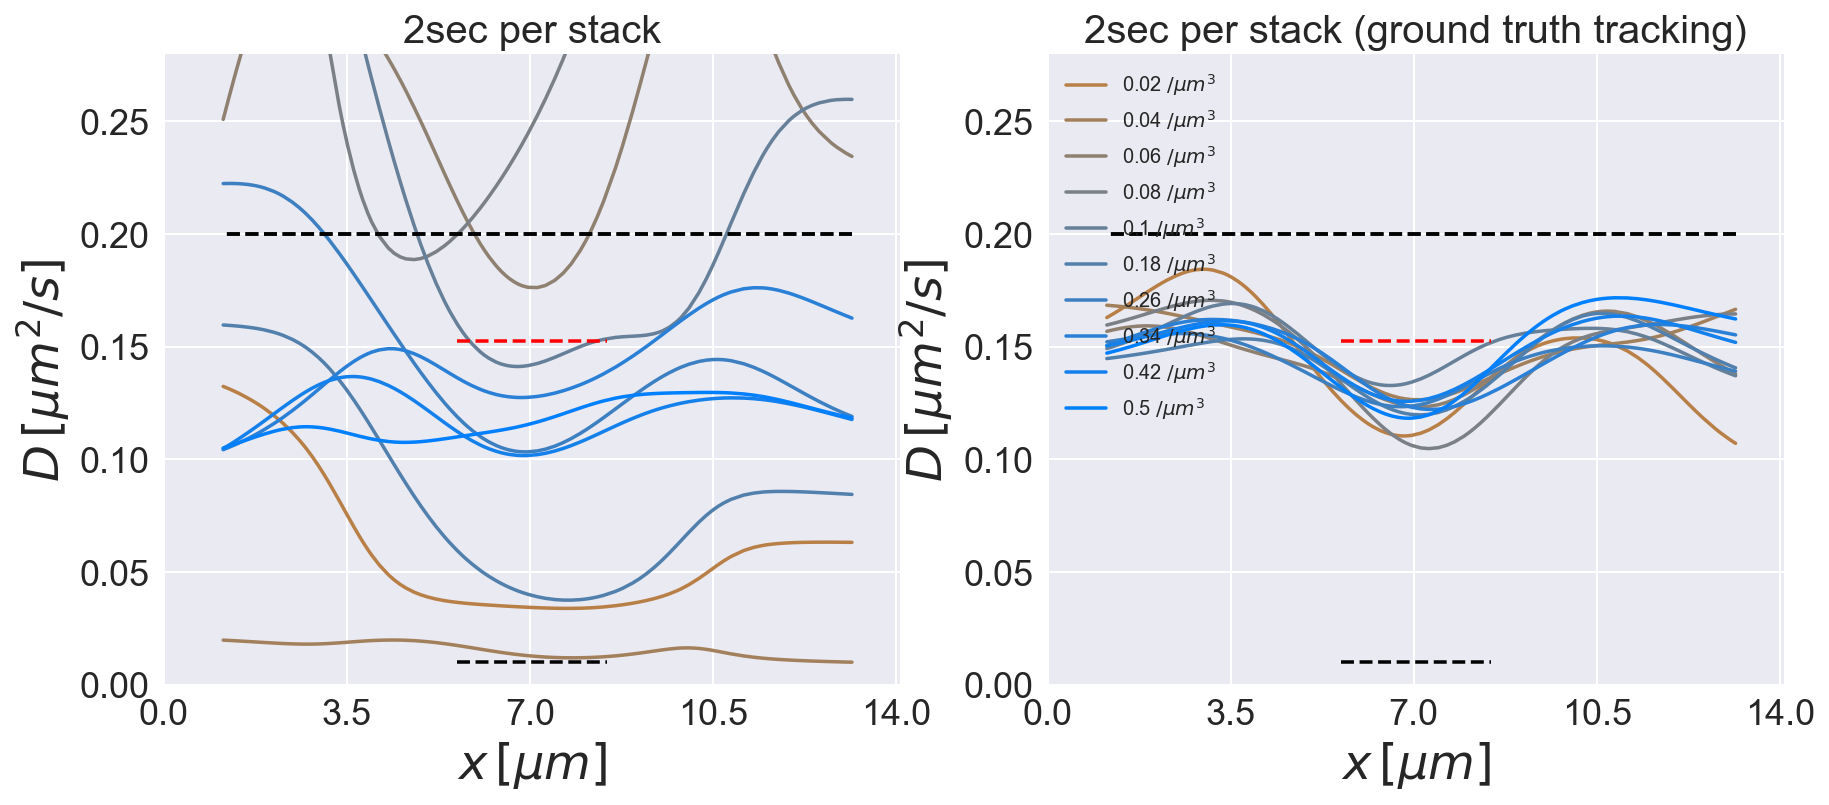

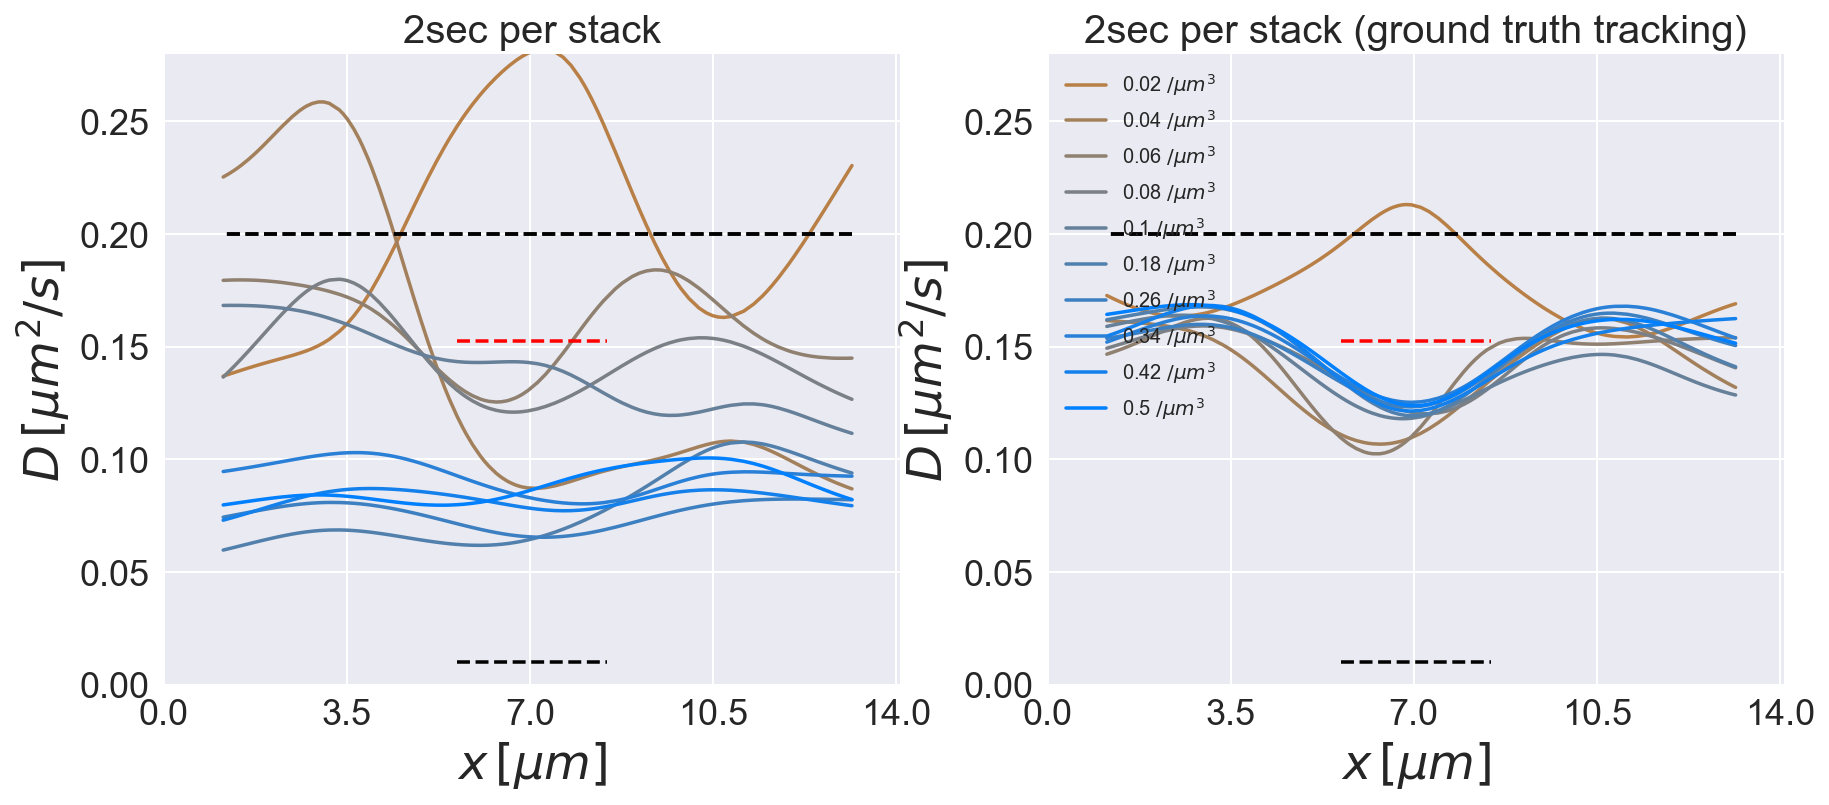

In [8]:
#0.7
plotTestSet(3, m=0, kind='B')
plotTestSet(3, m=1, kind='B')

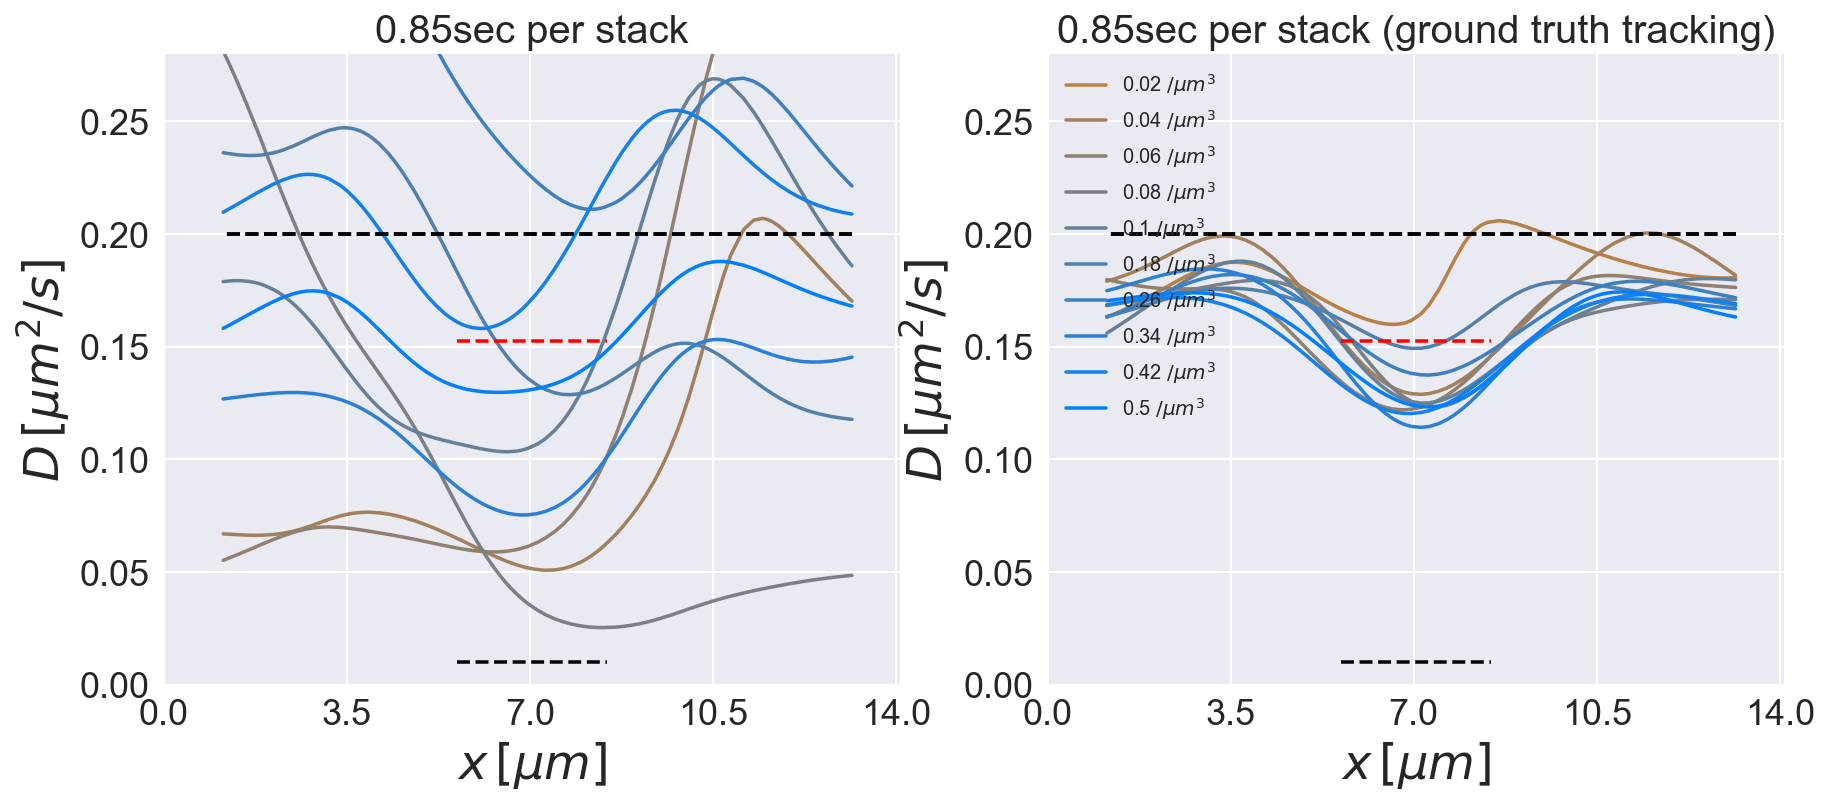

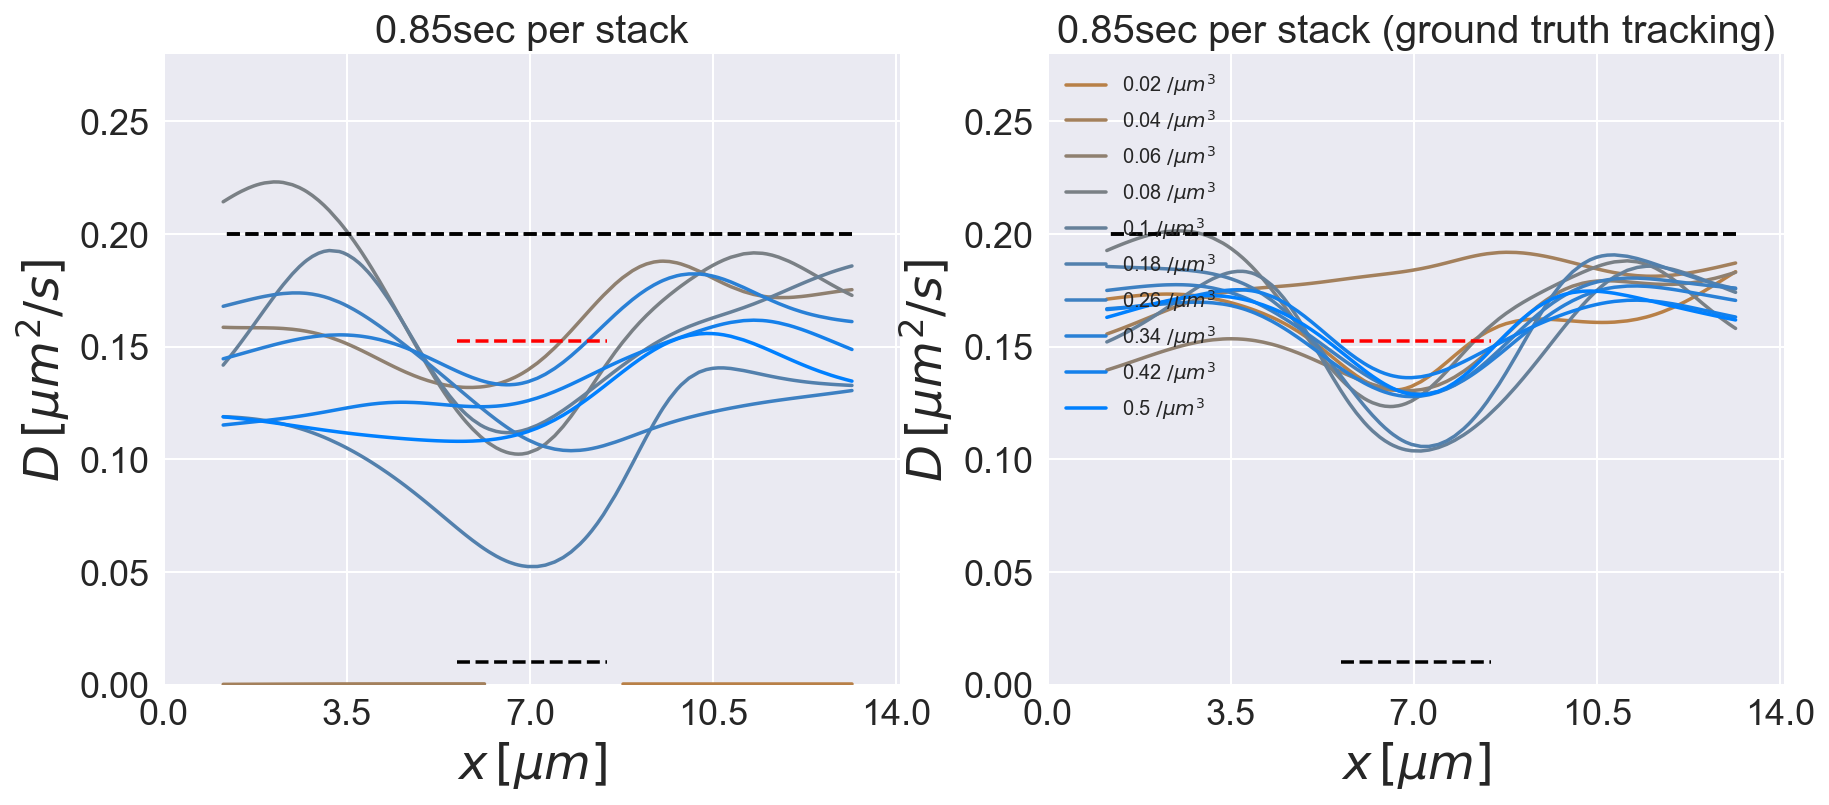

In [9]:
#0.65
plotTestSet(4, m=0, kind='B')
plotTestSet(4, m=1, kind='B')

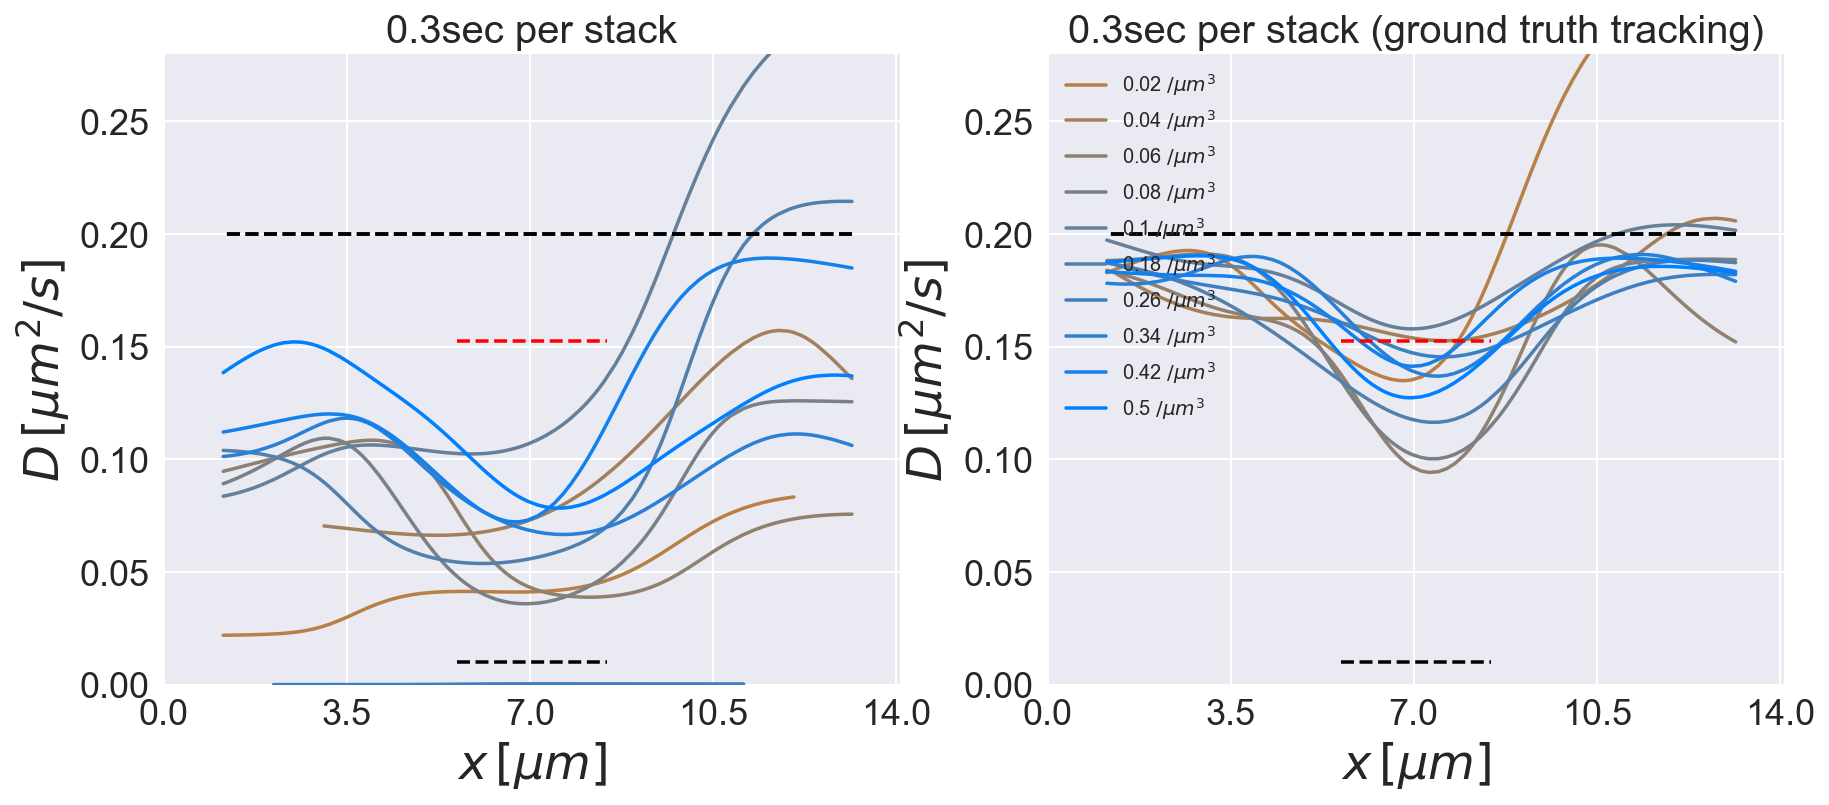

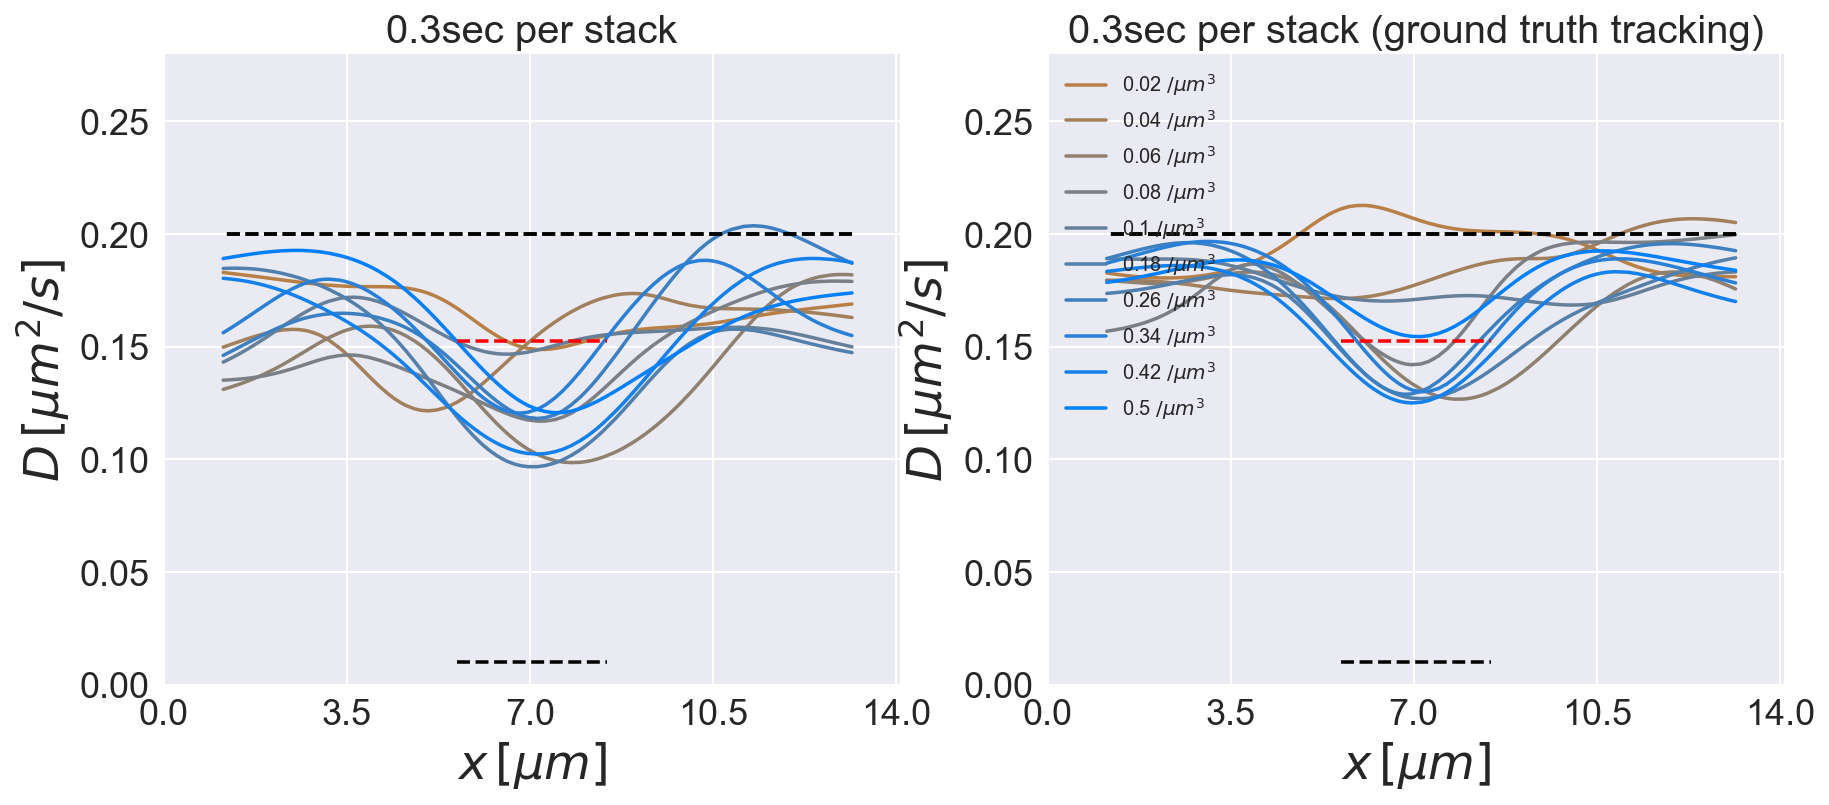

In [10]:
plotTestSet(5, m=0, kind='B')
plotTestSet(5, m=1, kind='B')

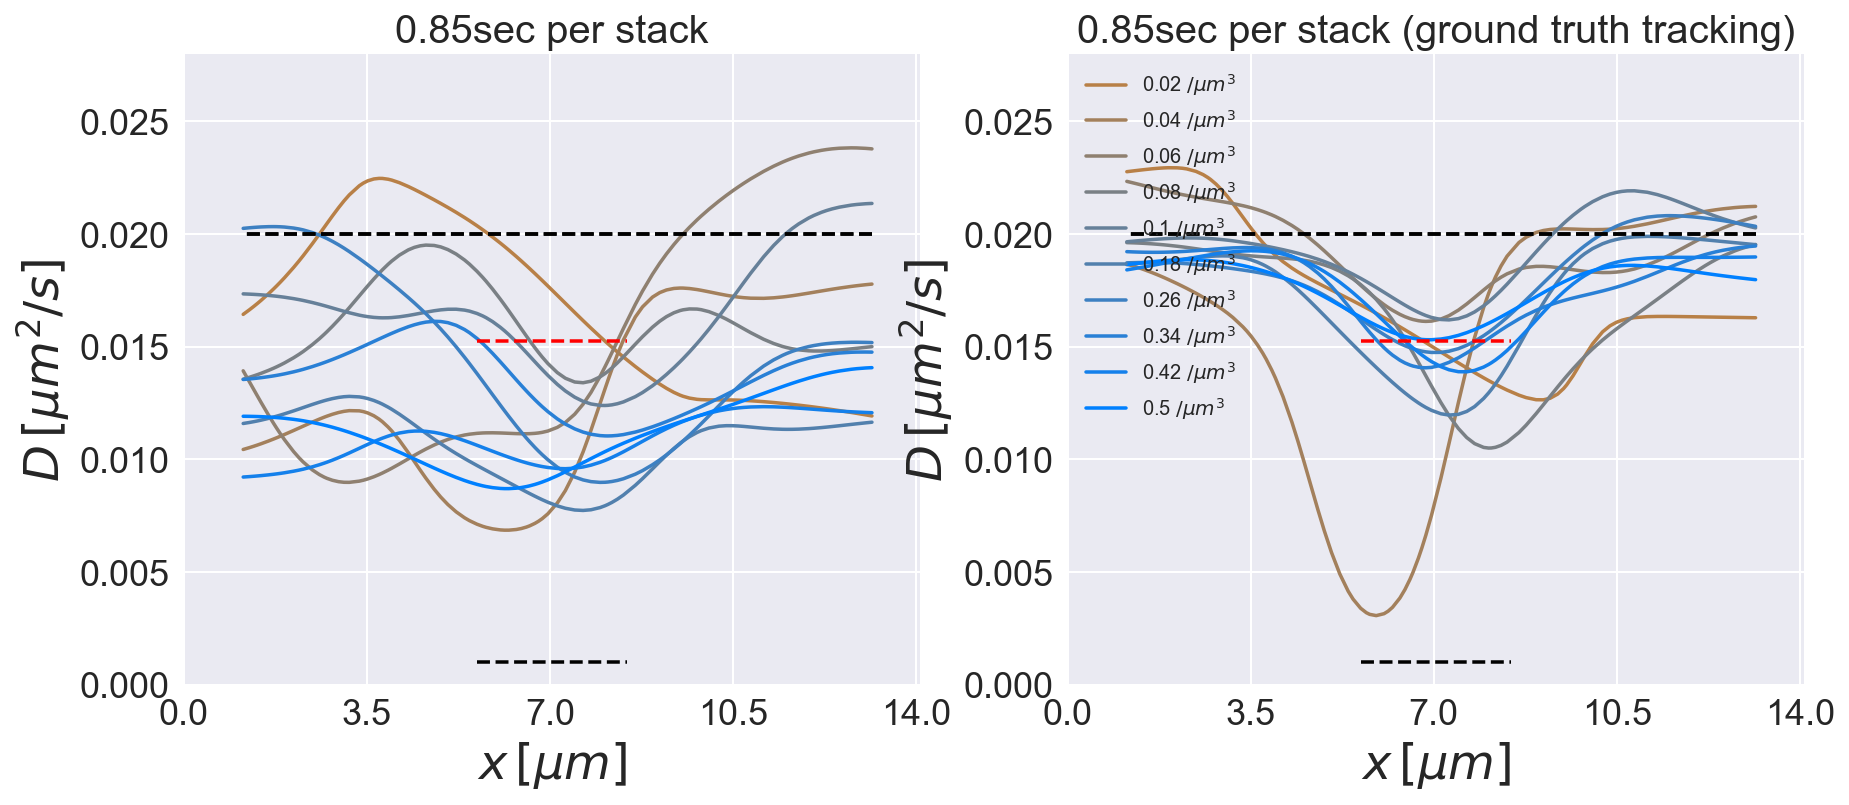

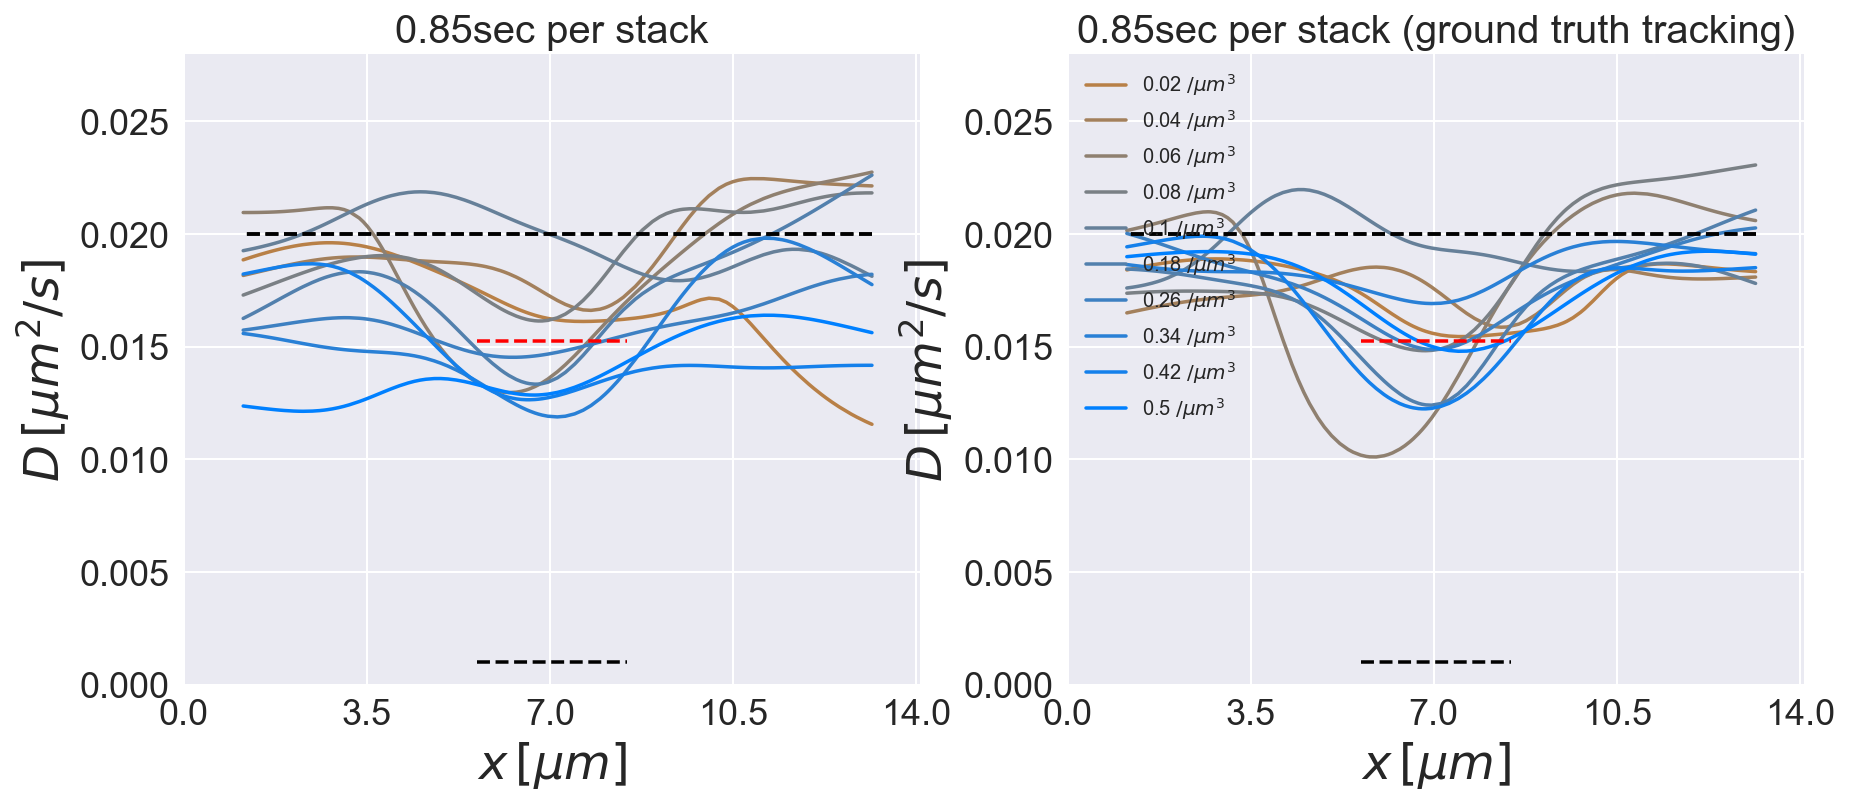

In [11]:
plotTestSet(6, m=0, kind='B')
plotTestSet(6, m=1, kind='B')

# ###

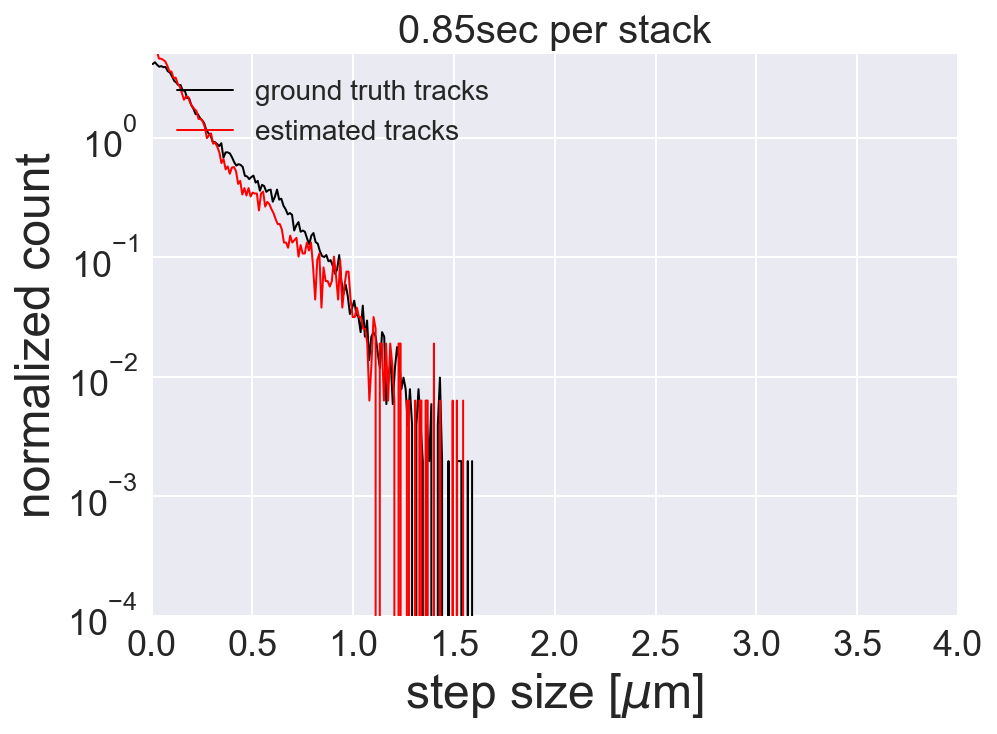

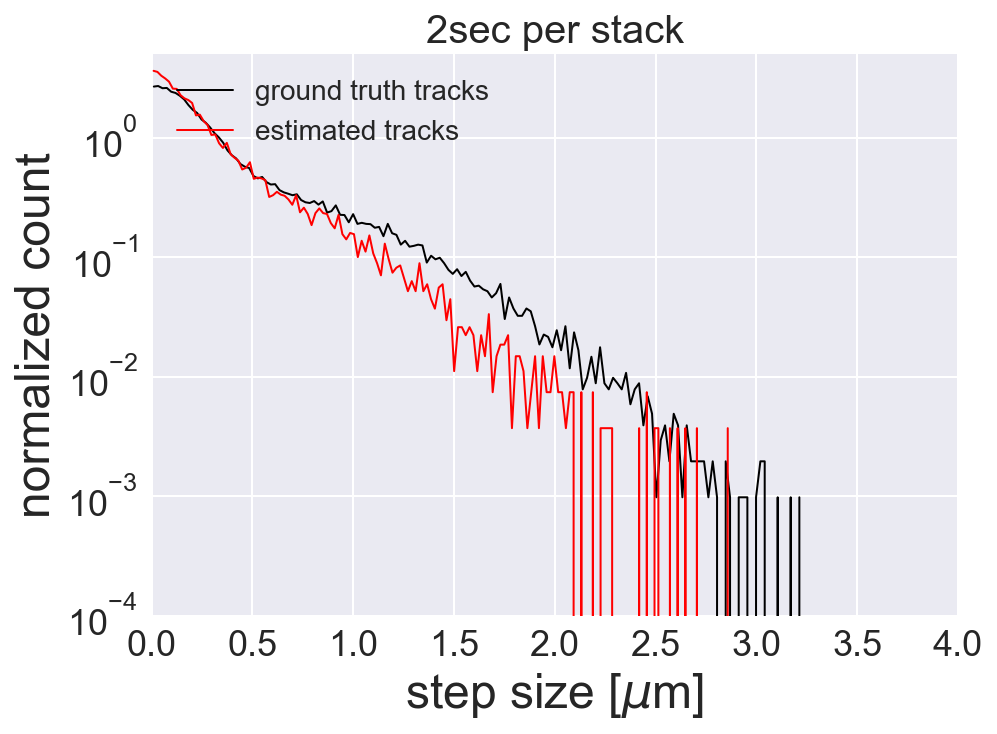

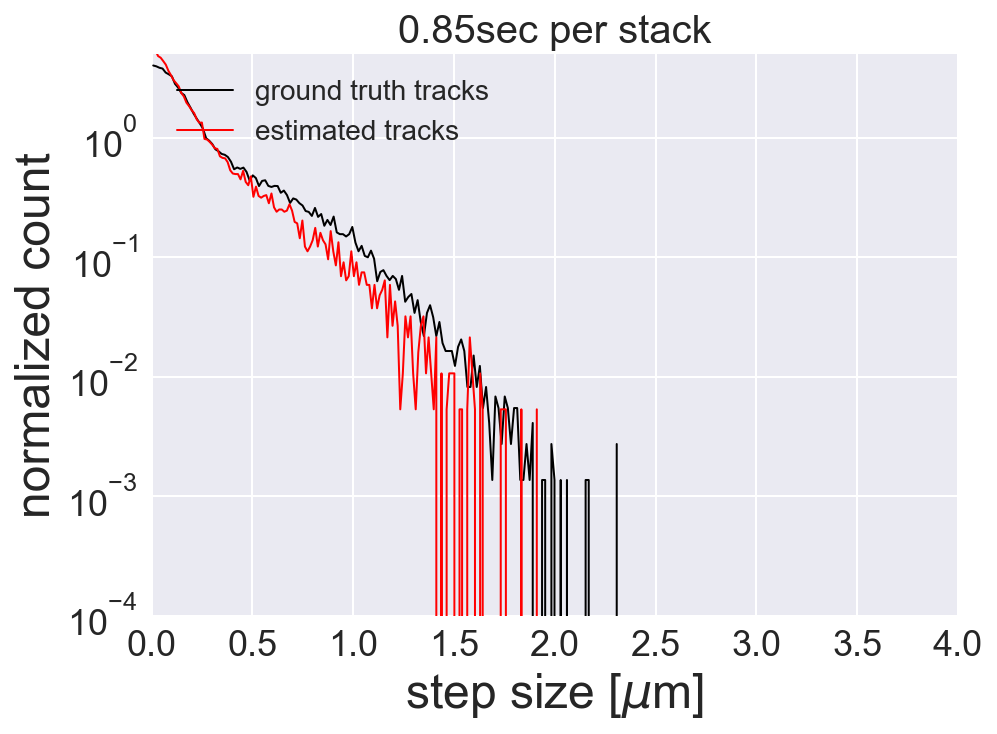

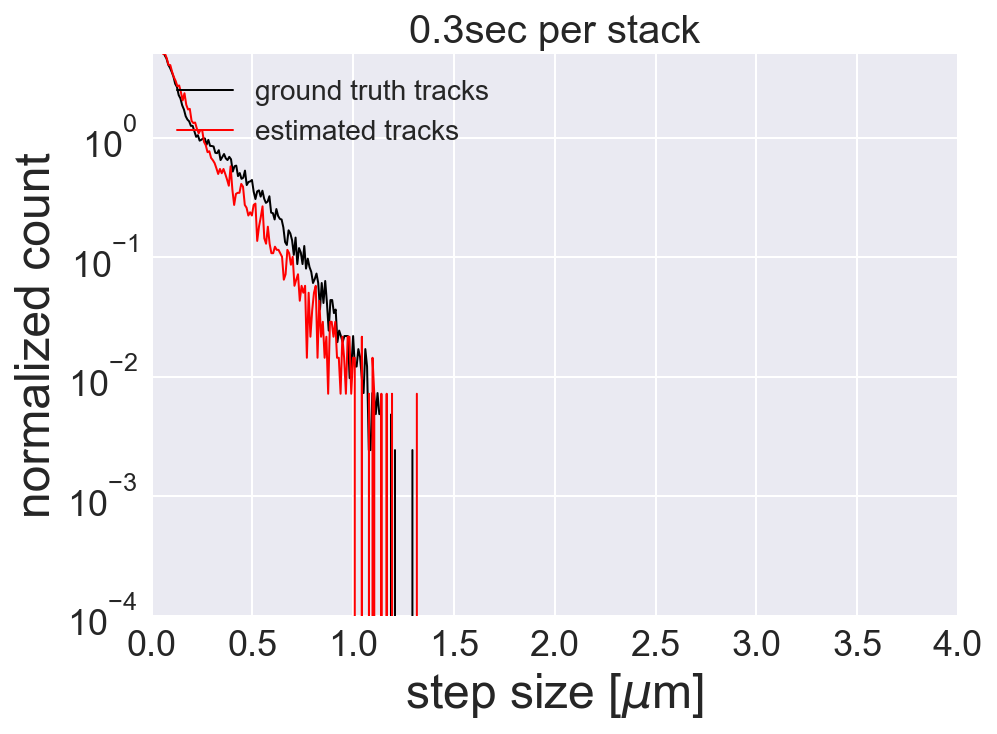

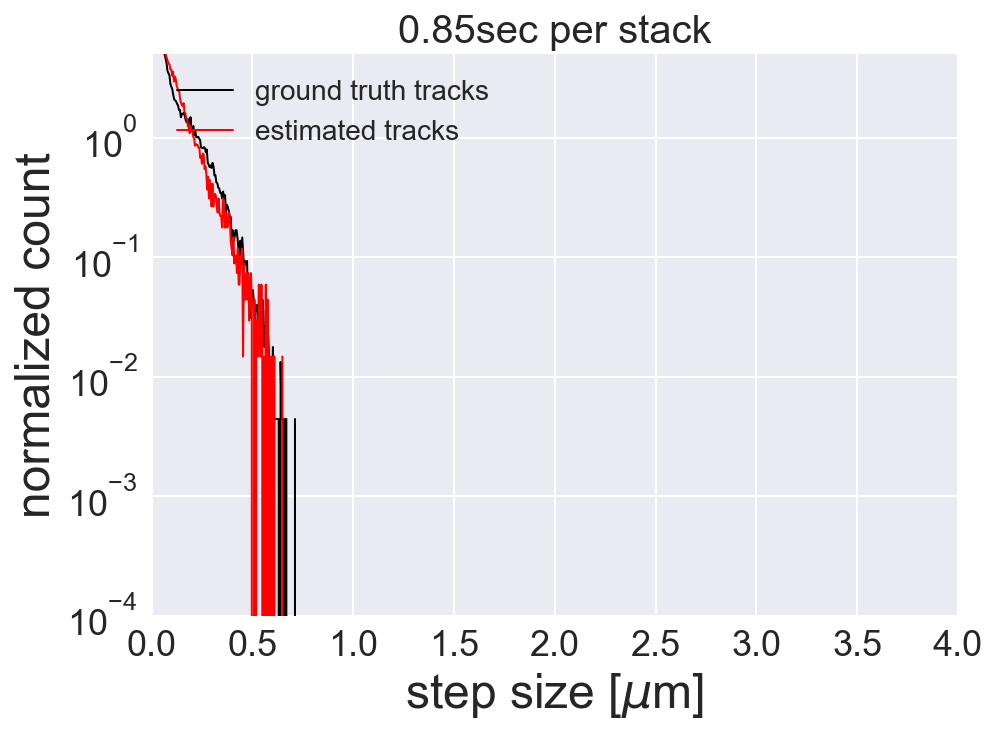

In [23]:
def plotTestSetHistograms(nset, kind='A', m=1):
    assert 1 <= nset <= 6
    Nvids = 104 if nset <= 1 else 20
    step = 5 if nset <= 1 else 2
    assert 0 <= m < step
        
    timings = [0.85, 0.85, 2., 0.85, 0.3, 0.85]
    fig1 = figure(1, [7, 5])
    dxy = 0.11
    dt = timings[nset-1]
    if nset == 1:
        kind = 'B'
        D0 = dxy**2/dt*array([0.4, 6])
        PAMP, NP = meshgrid(
            linspace(2, 100, 20),
            arange(5, 70, 10))
    elif nset == 2:
        D0 = array([0.01, 0.1])
        PAMP, NP = meshgrid(
            [25., 33.75],
            [5, 10, 15, 20, 25, 45, 65, 85, 105, 125, 145, 165, 185, 205])
    else:
        if nset in [3, 4, 5]:
            D0 = array([0.01, 0.2])
        if nset == 6:
            D0 = array([0.001, 0.02])
        PAMP, NP = meshgrid(
            [25., 33.75],
            [5, 10, 15, 20, 25, 45, 65, 85, 105, 125, 145, 165, 185, 205])
    r = 17*1.8/2.*dxy
    L = 128*dxy
    vol = 2.*pi*r**2*L
    def plotSet(m, gt=False):
        I = arange(m, Nvids, step)
        # I = arange(0, 5)
        N = I.size
        Dall = []
        Incs = []
        angles = []
        DperTrack = []
        trackLengths = []
        for n in I:
            afn = afn0 + '{0}-hyphaeList-withTracks.dtbin'.format(n)
            with DTDataFile(afn, readonly=True) as sfile:
                keys = [v for v in sfile.ordered_variable_names() if 'GEMS' in v]
                n2 = 0
                Np = 0
                Nt = 0
                while True:
                    if not 'Var_{0}_GEMS'.format(n2) in keys:
                        break
                    base = 'Var_{0}_'.format(n2)
                    points = array(sfile[base+'GEMS_points']).squeeze()
                    pointToParticle = array(sfile[base+'GEMS_pointToParticle']).squeeze()
                    particleToPoint = array(sfile[base + 'GEMS_particleToPoints']).squeeze()
                    time = array(sfile[base + 'GEMS_time']).squeeze()
                    if time.size == 0:
                        n2 += 1
                        continue
                    Np += points.shape[0]
                    Nt += time.max()
                    for (p, l) in particleToPoint.T:
                        track = points[p:p+l]
                        track_times = time[p:p+l]
                        vals = dxy**2/dt*(diff(track[:, :2], axis=0)**2).sum(axis=1)/diff(track_times)/4.
                        DperTrack.append(vals.mean())
                        trackLengths.append(vals.size)
                        DX = diff(track[:, :2], axis=0)
                        vals2 = dxy*DX.T/diff(track_times)
                        vals3 = arctan2(DX[:, 0], DX[:, 1])
                        #plot(track[:, 0], track[:, 1])
                        Dall.extend(vals)
                        Incs.extend(vals2.flatten())
                        angles.extend(vals3)
                    n2 += 1
        Incs = array(Incs)
        #print(Incs.mean(), Incs.std())
        H5, b5 = histogram(absolute(Incs), bins=150)
        x5 = b5[:-1] + 0.5*diff(b5)[0]
        c = 'k' if gt else 'r'
        l = 'ground truth tracks' if gt else 'estimated tracks'
        semilogy(x5, H5/trapz(H5, x5), c, lw=1, label=l)
        #semilogy(x5, H5, c, lw=1, label=l)
        ylabel('normalized count', fontsize=24)
        xlabel('step size [$\mu$m]', fontsize=24)
        xticks(fontsize=18)
        yticks(fontsize=18)
        title('{0:0.2g}sec per stack'.format(dt), fontsize=20)
    #############################################
    
    #############################################
    #fig1.add_subplot(121)
    if kind == 'B' and nset > 1:
        afn0 = 'synthetic_tests_gt/test{0}bgt/'.format(nset)
    else:
        afn0 = 'synthetic_tests_gt/test{0}gt/'.format(nset)
    plotSet(m, True)
    
    if kind == 'B' and nset > 1:
        afn0 = 'synthetic_tests/test{0}b/'.format(nset)
    else:
        afn0 = 'synthetic_tests/test{0}/'.format(nset)
    plotSet(m, False)
    ylim(1e-4, 5)
    xlim(0, 4)
    legend(fontsize=14, ncol=1, loc='upper left')

    subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.93)
    draw();
    if kind == 'A' and m > 0:
        savefig('fig_test_{0} (stepsize).pdf'.format(nset))
        savefig('fig_test_{0} (stepsize).png'.format(nset), dpi=300)
    show();
    
plotTestSetHistograms(2, m=1)
plotTestSetHistograms(3, m=1)
plotTestSetHistograms(4, m=1)
plotTestSetHistograms(5, m=1)
plotTestSetHistograms(6, m=1)

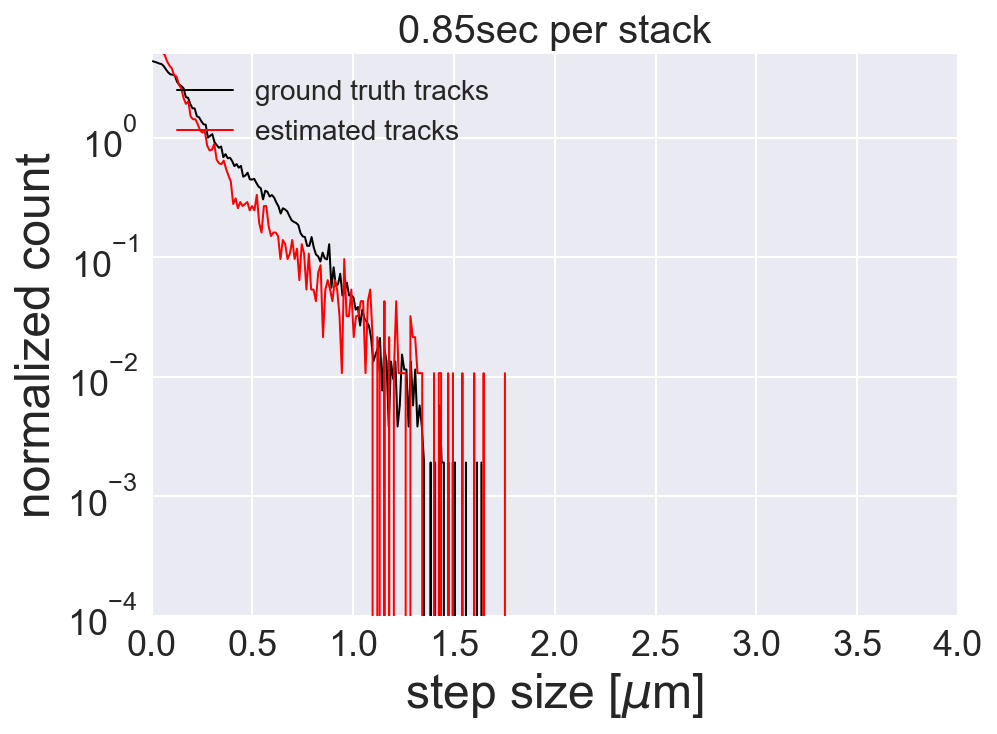

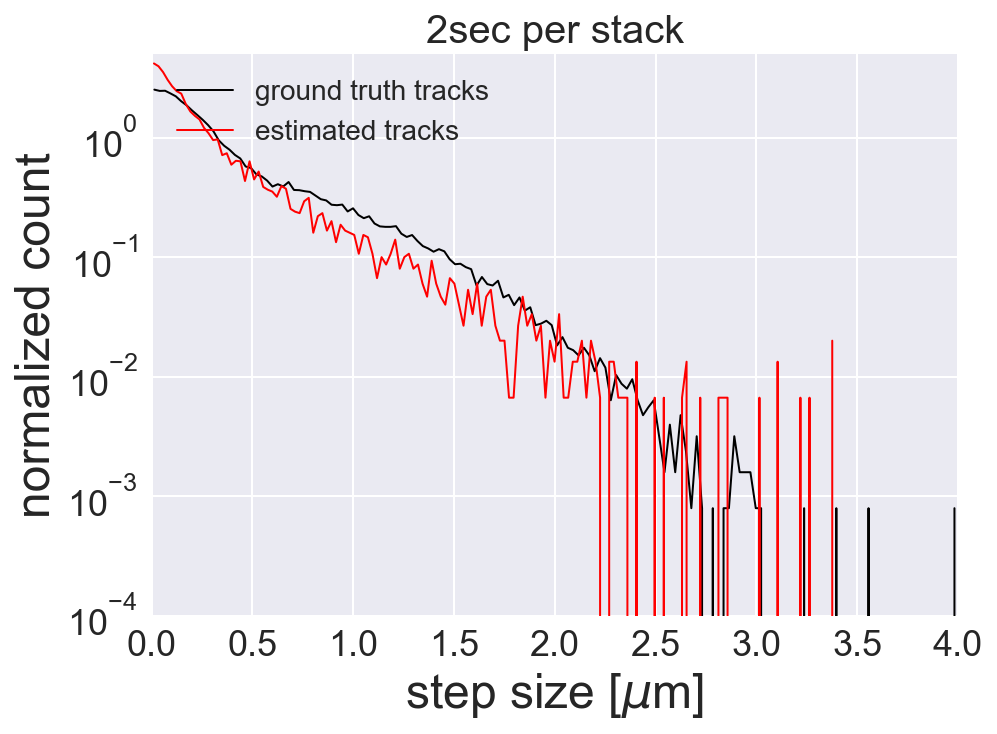

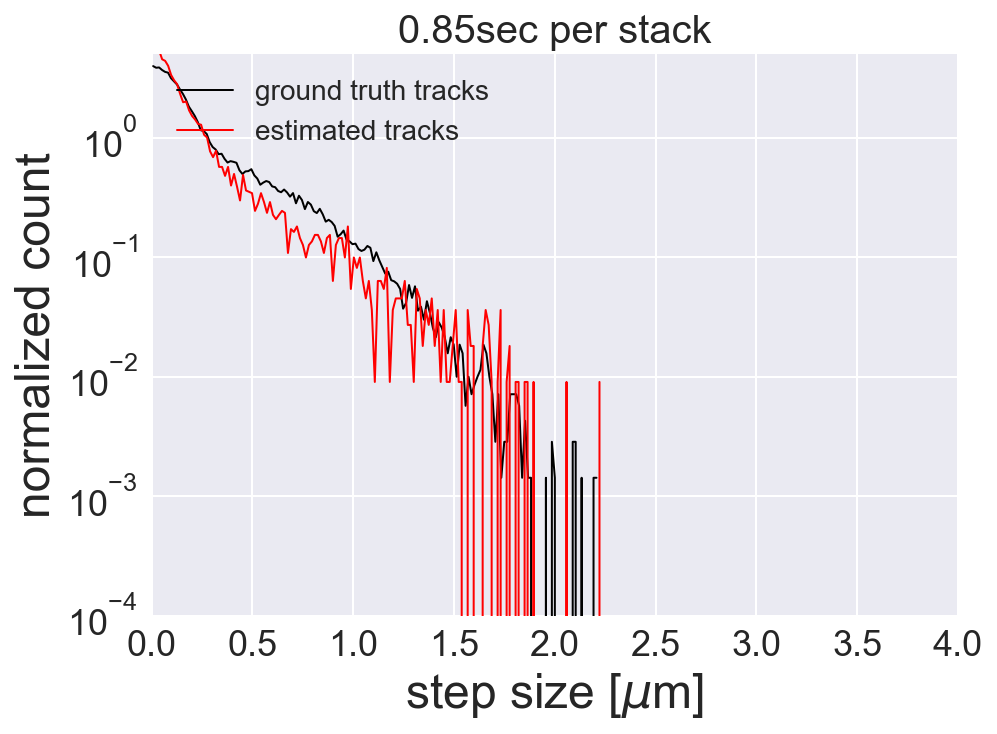

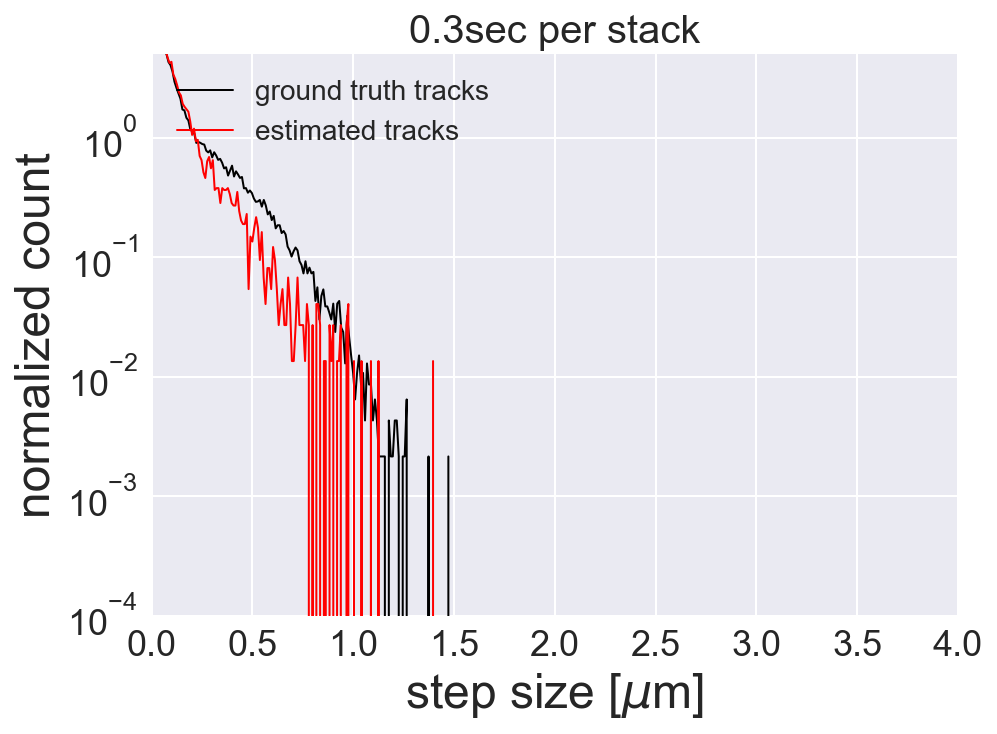

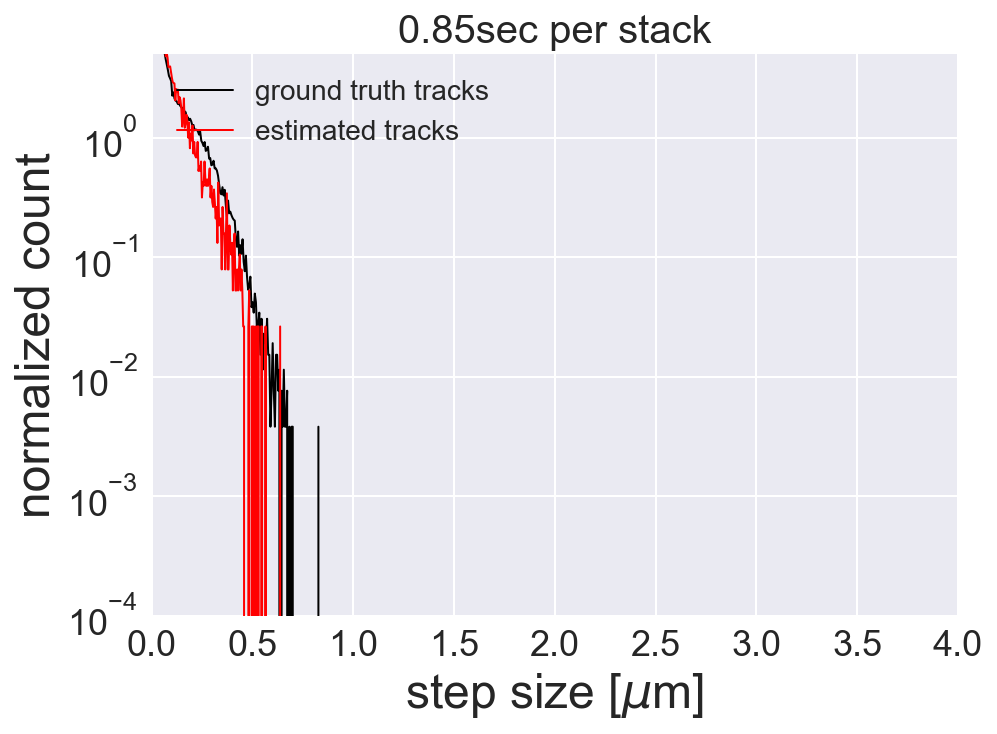

In [24]:
plotTestSetHistograms(2, m=0)
plotTestSetHistograms(3, m=0)
plotTestSetHistograms(4, m=0)
plotTestSetHistograms(5, m=0)
plotTestSetHistograms(6, m=0)

In [25]:
# plotTestSetHistograms(2, m=1, kind='B')
# plotTestSetHistograms(3, m=1, kind='B')
# plotTestSetHistograms(4, m=1, kind='B')
# plotTestSetHistograms(5, m=1, kind='B')
# plotTestSetHistograms(6, m=1, kind='B')

In [26]:
# plotTestSetHistograms(2, m=0, kind='B')
# plotTestSetHistograms(3, m=0, kind='B')
# plotTestSetHistograms(4, m=0, kind='B')
# plotTestSetHistograms(5, m=0, kind='B')
# plotTestSetHistograms(6, m=0, kind='B')

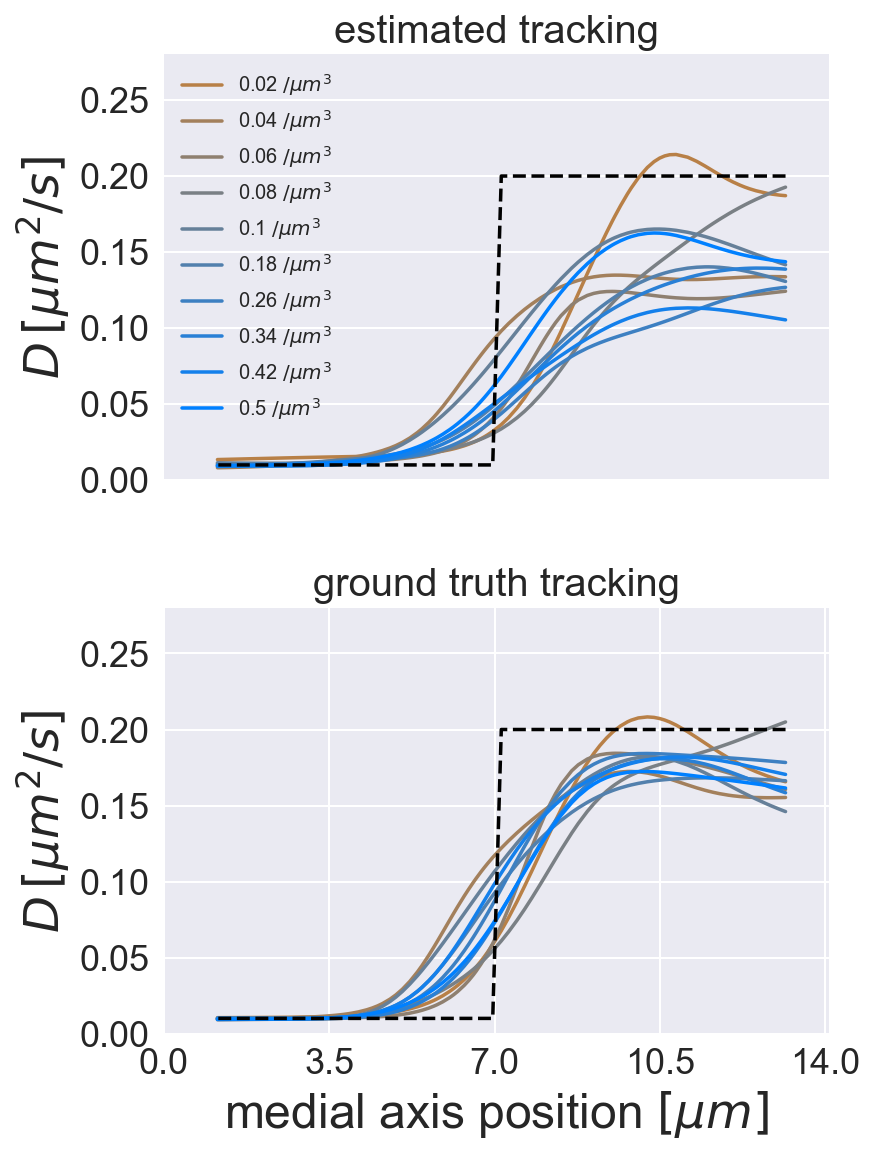

In [80]:
def plotTestSet(nset, kind='A', m=1):
    assert 1 <= nset <= 6
    Nvids = 104 if nset <= 1 else 20
    step = 5 if nset <= 1 else 2
    assert 0 <= m < step
    timings = [0.85, 0.85, 2., 0.85, 0.3, 0.85]
    fig1 = figure(1, [6, 8])
    dxy = 0.11
    dt = timings[nset-1]
    if nset == 1:
        kind = 'B'
        D0 = dxy**2/dt*array([0.4, 6])
        PAMP, NP = meshgrid(
            linspace(2, 100, 20),
            arange(5, 70, 10))
    elif nset == 2:
        D0 = array([0.01, 0.1])
        PAMP, NP = meshgrid(
            [25., 33.75],
            [5, 10, 15, 20, 25, 45, 65, 85, 105, 125, 145, 165, 185, 205])
    else:
        if nset in [3, 4, 5]:
            D0 = array([0.01, 0.2])
        if nset == 6:
            D0 = array([0.001, 0.02])
        PAMP, NP = meshgrid(
            [25., 33.75],
            [5, 10, 15, 20, 25, 45, 65, 85, 105, 125, 145, 165, 185, 205])
    r = 17*1.8/2.*dxy
    L = 128*dxy
    vol = 2.*pi*r**2*L
    def plotSet(m, gt=False):
        I = arange(m, Nvids, step)
        # I = arange(0, 5)
        N = I.size
        colors = 0.8*(arange(1.*N)/N)[::-1]
        for n, c in zip(I, colors):
            afn = afn0 + '{0}-hyphaAxisDensity.dtbin'.format(n)
            with DTDataFile(afn, readonly=True) as sfile:
                #print(sfile.variable_names())
                if array(sfile['Var_0_arcLength']).size <= 1:
                    continue
                AL = array(sfile['Var_0_arcLength']).squeeze()
                ALxyz = array(sfile['Var_0_axisPosition']).squeeze()
                avg_D = array(sfile['Var_0_diffusivity']).squeeze()
                min_proj_D = array(sfile['Var_0_minProjection']).squeeze()
            plot(
                dxy*ALxyz[0], 
                dxy**2/dt*avg_D[:, -1], 
                color=(c, .5, 1-c), 
                label='{0:0.2g} $/\mu m^3$'.format(NP.flatten()[n]/vol))
            
        if kind == 'A':
            sy = D0[1]*ones(ALxyz[0].size)
            sy[ALxyz[0] < 64] = D0[0]
        else:
            sy = D0[1]*ones(ALxyz[0].size)
            plot(dxy*ALxyz[0], sy, '--k')
            s = linspace(51, 77)
            p = 0.25#0.5**2/(0.5**2 + D0[0]/D0[1])
            plot(dxy*s, (D0[0]*p + D0[1]*(1-p))*ones(s.size), '--r')#, label='volume average')
            plot(dxy*s, D0[0]*ones(s.size), '--k')
        plot(dxy*ALxyz[0], sy, '--k')
        xticks([0, 3.5, 7, 10.5, 14], fontsize=18)
        #yticks([0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24], fontsize=18)
        yticks(fontsize=18)
        xlim(0, dxy*128)
        if m == 0:
            ylim(0, D0[1]*1.4)
        else:
            ylim(0, D0[1]*1.4)
        
        if gt:
            #title('{0:0.2g}sec per stack\n(ground truth tracking)'.format(dt), fontsize=20)
            title('ground truth tracking'.format(dt), fontsize=20)
        else:
            title('estimated tracking'.format(dt), fontsize=20)
            #title('{0:0.2g}sec per stack'.format(dt), fontsize=20)
    #############################################
    path1 = '../Axial_Projections/net_tracker_testing (axialDensityData)/'
    if kind == 'B' and nset > 1:
        afn0 = path1 + 'synthetic_tests/test{0}b/'.format(nset)
    else:
        afn0 = path1 + 'synthetic_tests/test{0}/'.format(nset)
    #############################################
    fig1.add_subplot(211)
    plotSet(m, False)
    xticks([])
    ylabel('$D\, [\mu m^2/s]$', fontsize=24);
    legend(fontsize=10, ncol=1, loc='upper left')
    
    #############################################
    if kind == 'B' and nset > 1:
        afn0 = path1 + 'synthetic_tests_gt/test{0}bgt/'.format(nset)
    else:
        afn0 = path1 + 'synthetic_tests_gt/test{0}gt/'.format(nset)
    #############################################
    fig1.add_subplot(212)
    plotSet(m, True)
    xlabel('medial axis position $[\mu m]$', fontsize=24);
    ylabel('$D\, [\mu m^2/s]$', fontsize=24);
    

    subplots_adjust(left=0.18, bottom=0.1, top=0.95, right=0.95, hspace=0.3)
    #show();draw();
    if kind == 'A':
        if m > 0:
            savefig('fig2CD-b.pdf'.format(nset))

plotTestSet(4, m=1)

In [103]:
x = 1e-3 + (0.1 - 1e-3)*rand(10, 10)
x[0] = 0.1
cmap_fn = '../DataTankCode/more_cmaps/rainbow_bgyr_35-85_c73_n256.csv'
df = array(pd.read_csv(cmap_fn))
print(df.shape)
cdata = {
    'red': df[:, 0]/256.,
    'green': df[:, 1]/256.,
    'blue': df[:, 2]/256.,
}
# cmap = cm.colors.LinearSegmentedColormap('testing', cdata)
cmp = cm.colors.
?cmp
# figure(1)
# imshow(x, cmap=cmap)
# colorbar()


(255, 3)
